# Imports and Data

In [111]:
def oldcalls(infile, filt, ego, alter, timestamp, tstampformat, header=True, min_activity=1):
    '''
    Old code for the method "allcalls". The updated version is in this module.
    This method takes a file (argument infile), usually in .csv format,
    and process it only to obtain a dataframe with columns [ego, alter,
    timestamp, universal clock, alter clock]. In order to produce that,
    it uses the following arguments
    filt            : in case you need to filter phone calls (incoming, etc.)
                    it can be an empty tuple, in case there are no filters. The first element of the
                    tuple is the label/number of the column to filter.
    ego             : which column (label or number) contains the id for ego
    alter           : same as above, for alter's identifier
    timestamp       : a list with the label(s) for the timestamp
    tsstampformat   : Python's format specification to parse dates. Look at the
                    documentation for the "datetime" module for further reference
                    https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
    header          : does the original file contains headers? It is a boolean value
                    that defualts to "True"
    min_activity    : the minimum number of phone calls between ego and alter to keep
                    the phone calls for this pair in the resulting dataframe. It
                    defaults to 1, or keep all phone calls.
    '''
    if header:
        df = pd.read_csv(infile)
        tmp = pd.DataFrame()
        if len(filt) > 2:
            for i in range(1, len(filt)):
                df2 = df.loc[df[filt[0]] == filt[i]]
                tmp = tmp.append(df2)
        elif len(filt) == 2:
            tmp = df.loc[df[filt[0]] == filt[1]]
        else:
            tmp = copy.deepcopy(df)
    else:
        df = pd.read_csv(infile, header=None)
        tmp = pd.DataFrame()
        if len(filt) > 2:
            for i in range(1, len(filt)):
                df2 = df.loc[df[filt[0]] == filt[i]]
                tmp = tmp.append(df2)
        elif len(filt) == 2:
            tmp = df.loc[df[filt[0]] == filt[1]]
        else:
            tmp = copy.deepcopy(df)

    egocol = tmp[ego]
    altercol = tmp[alter]
    newdf = pd.DataFrame({'ego': egocol, 'alter': altercol})
    timecol = tmp[timestamp]
    if len(timecol.columns) > 1:
        for i in list(timecol.columns):
            if i == list(timecol.columns)[0]:
                newdf['time'] = timecol[i] + " "
            elif i != list(timecol.columns)[-1]:
                newdf['time'] += timecol[i] + " "
            else:
                newdf['time'] += timecol[i]
    else:
        newdf['time'] = timecol

    newdf['time'] = pd.to_datetime(newdf['time'], format=tstampformat)
    newdf.sort_values(by=['alter', 'ego', 'time'], ascending=[True, True, True], inplace=True)
    newdf['no'] = 1
    newdf['no'] = newdf.groupby(['alter', 'ego'])[['no']].cumsum()
    newdf['no'] -= 1

    tmp = newdf.groupby(['ego', 'alter'])[['no']].max().reset_index()
    tmp.columns = ['ego', 'alter', 'ma']
    tmp['ma'] += 1
    newdf = newdf.merge(tmp, on=['ego', 'alter'])
    newdf = newdf.loc[newdf['ma'] >= min_activity]

    mindate = min(newdf['time'])
    newdf['uclock'] = (newdf.loc[:, 'time'] - mindate).dt.days
    newdf.loc[:, 'firstcall'] = False
    newdf.loc[newdf['no'] == 0, 'firstcall'] = True
    tmp = newdf.loc[newdf['firstcall'], ['ego', 'alter', 'uclock']]
    tmp.columns = ['ego', 'alter', 'fcall']
    newdf = newdf.merge(tmp, left_on=['ego', 'alter'], right_on=['ego', 'alter'])
    newdf['aclock'] = newdf['uclock'] - newdf['fcall']
    newdf.drop(columns=['fcall', 'firstcall', 'no', 'ma'], inplace=True)
    newdf = newdf.astype({'uclock': int, 'aclock': int})
    newdf.reset_index(drop=True, inplace=True)

    return newdf

In [125]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_unfiltered.pickle', 'rb') as handle:
    tmpunf = pickle.load(handle)
    handle.close()
    
unfiltered.update(tmpunf)

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
unfiltered['mit'] = oldcalls('../usadata/CallLog.csv', ('type', 'outgoing', 'outgoing+', 'missed'), 'participantID.A', 'number.hash', 
                                ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
unfiltered['uk12'] = pd.DataFrame()
for c in ['uk1', 'uk2']:
    df = unfiltered[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    unfiltered['uk12'] = unfiltered['uk12'].append(df)

L = {'uk': 300, 'uk1': 300, 'uk2': 270, 'it': 365, 'itb': 365, 'mit': 220}
calls = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    calls[c] = pc.apply_filters(df, 60)
calls['uk12'] = pd.DataFrame()
for c in ['uk1', 'uk2']:
    df = calls[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    calls['uk12'] = calls['uk12'].append(df)
    
    
globalt0 = dt.datetime.now()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fig 1 with resampling
The resampling is all about making all cohorts comparable.

In [126]:
for c in ['it', 'mit']:
    # No Filter
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    print(c, len(df['ea'].unique()))
    # L
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    print(c, len(df['ea'].unique()))
    # ncalls = df.groupby('ea')[['time']].count()
    # keep = ncalls.loc[ncalls['time'] >= 3]
    # df = df[df['ea'].isin(keep.index)]
    # calls[{'it': 'itL', 'mit': 'mitL'}[c]] = df
    # print(c, len(df['ea'].unique()))
    # Delta t to the left (by ego)
    t0i = df.groupby('ego')['uclock'].min()
    print(t0i[24])
    t0x = df.groupby('ea')[['uclock']].min()
    t0x['dif'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
    keep = t0x.loc[t0x['dif'] > 50]
    df = df[df['ea'].isin(keep.index)]
    print(len(df['ea'].unique()))
    # Delta t to the right
    df = pc.apply_filters(df, 60)
    if c == 'it':
        df['uclock'] -= 51
    df['ea'] = list(zip(df['ego'], df['alter']))
    print(len(df['ea'].unique()))
    calls[{'it': 'itb', 'mit': 'mitb'}[c]] = df

it 23674
it 21064
4
17501
2736
mit 12431
mit 11792
216
8743
1963


In [127]:
for c in calls.keys():
    calls[c]['ea'] = list(zip(calls[c]['ego'], calls[c]['alter']))
    print(c, [min(calls[c]['uclock']), max(calls[c]['uclock'])], [min(calls[c]['aclock']), max(calls[c]['aclock'])], len(calls[c]['ea'].unique()))

uk [0, 483] [0, 300] 1650
uk1 [0, 411] [0, 300] 709
uk2 [0, 303] [0, 268] 920
it [0, 638] [0, 365] 4052
mit [1, 444] [0, 220] 3216
uk12 [0, 411] [0, 300] 1629
itb [0, 587] [0, 365] 2736
mitb [134, 444] [0, 218] 1963


In [128]:
tmp = calls['itb'].copy(deep=True)
tmp['ea'] = list(zip(tmp['ego'], tmp['alter']))
t0i = tmp.groupby('ego')['uclock'].min()
t0x = tmp.groupby('ea')[['uclock']].min()
t0x['t0'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
tmp2 = t0x.loc[t0x['t0'] > 50]
df = tmp[tmp['ea'].isin(tmp2.index)]

In [129]:
t0i[24]

4

In [118]:
df.loc[df['ea'] == (24, '86103645de92f7239441067a8cb8146')]

Empty DataFrame
Columns: [ego, alter, time, uclock, aclock, ea]
Index: []

In [8]:
# npairs = {}
# for c in ['itu', 'mitu', 'itu3', 'mitu3', 'it', 'itb', 'itL', 'mit', 'mitb', 'mitL']:
#     if c in ['itu', 'mitu']:
#         df = unfiltered[{'itu': 'it', 'mitu': 'mit'}[c]].copy(deep=True)
#     elif c in ['itu3', 'mitu3']:
#         df = unfiltered[{'itu3': 'it', 'mitu3': 'mit'}[c]].copy(deep=True)
#         df['ea'] = list(zip(df['ego'], df['alter']))
#         ncalls = df.groupby('ea')[['time']].count()
#         keep = ncalls.loc[ncalls['time'] >= 3]
#         df = df[df['ea'].isin(keep.index)]
#     else:
#         df = calls[c].copy(deep=True)
#     df['ea'] = list(zip(df['ego'], df['alter']))
#     npairs[c] = len(df['ea'].unique())
    
# print('itu to itu3', (npairs['itu'] - npairs['itu3']), (npairs['itu'] - npairs['itu3']) / npairs['itu'])    
# print('itu3 to it', (npairs['itu3'] - npairs['it']), (npairs['itu3'] - npairs['it']) / npairs['itu3'])
# print('itu3 to itb', (npairs['itu3'] - npairs['itb']), (npairs['itu3'] - npairs['itb']) / npairs['itu3'])
# print('itu3 to itL', (npairs['itu3'] - npairs['itL']), (npairs['itu3'] - npairs['itL']) / npairs['itu3'])
# print('itL to it', (npairs['itL'] - npairs['it']), (npairs['itL'] - npairs['it']) / npairs['itL'])
# print('it to itb', (npairs['it'] - npairs['itb']), (npairs['it'] - npairs['itb']) / npairs['it'])
# print('itL to itb', (npairs['itL'] - npairs['itb']), (npairs['itL'] - npairs['itb']) / npairs['itL'])
# print('mitu to mitu3', (npairs['mitu'] - npairs['mitu3']), (npairs['mitu'] - npairs['mitu3']) / npairs['mitu'])
# print('mitu3 to mitL', (npairs['mitu'] - npairs['mitL']), (npairs['mitu'] - npairs['mitL']) / npairs['mitu'])
# print('mitu3 to mit', (npairs['mitu3'] - npairs['mit']), (npairs['mitu3'] - npairs['mit']) / npairs['mitu3'])
# print('mitu3 to mitb', (npairs['mitu3'] - npairs['mitb']), (npairs['mitu3'] - npairs['mitb']) / npairs['mitu3'])
# print('mitL to mit', (npairs['mitL'] - npairs['mit']), (npairs['mitL'] - npairs['mit']) / npairs['mitL'])
# print('mit to mitb', (npairs['mit'] - npairs['mitb']), (npairs['mit'] - npairs['mitb']) / npairs['mit'])
# print('mitL to mitb', (npairs['mitL'] - npairs['mitb']), (npairs['mitL'] - npairs['mitb']) / npairs['mitL'])

In [9]:
# npairs['it'] / 143

In [130]:
lives = {}
lives['all'] = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    lives[c] = pc.lives_dictionary(calls[c])
    lives['all'].update(lives[c])

In [131]:
limits = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    limits[c] = []
    limits[c].append((0, 50))
    limits[c].append((L[c] // 2 - 25, L[c]//2 + 25))
    limits[c].append((L[c] - 50, L[c]))
limits

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'itb': [(0, 50), (157, 207), (315, 365)],
 'it': [(0, 50), (157, 207), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

In [12]:
# limits['it'] = [(0, 50), (150, 200), (270, 320)]

In [176]:
t0 = dt.datetime.now()
fig1 = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15, countalters=True)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:02.172788


In [177]:
dashed = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
            points = pc.get_b_slopes(fig1[c][lamb]['f'])
            # print(pc.get_b_mk(fig1[c][lamb]['f']))
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk2=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.663175464631242) -- (axis cs: 2, 0.663175464631242);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.87373430853823) -- (axis cs: 9, 1.87373430853823);
\draw[dashed, ekans, ultra thick] (axis cs: 3, 2.448535988086695) -- (axis cs: 13, 2.448535988086695);
=======================itb=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.5495548728469455) -- (axis cs: 2, 0.5495548728469455);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.8390481094780258) -- (axis cs: 12, 0.8390481094780258);
\draw[dashed, ekans, ultra thick] (axis cs: 2, 1.9626562663754517) -- (axis cs: 21, 1.9626562663754517);
=======================it=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.551795638030544) -- (axis cs: 2, 0.551795638030544);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.7250957211167651) -- (axis cs: 12, 0.7250957211167651);
\draw[d

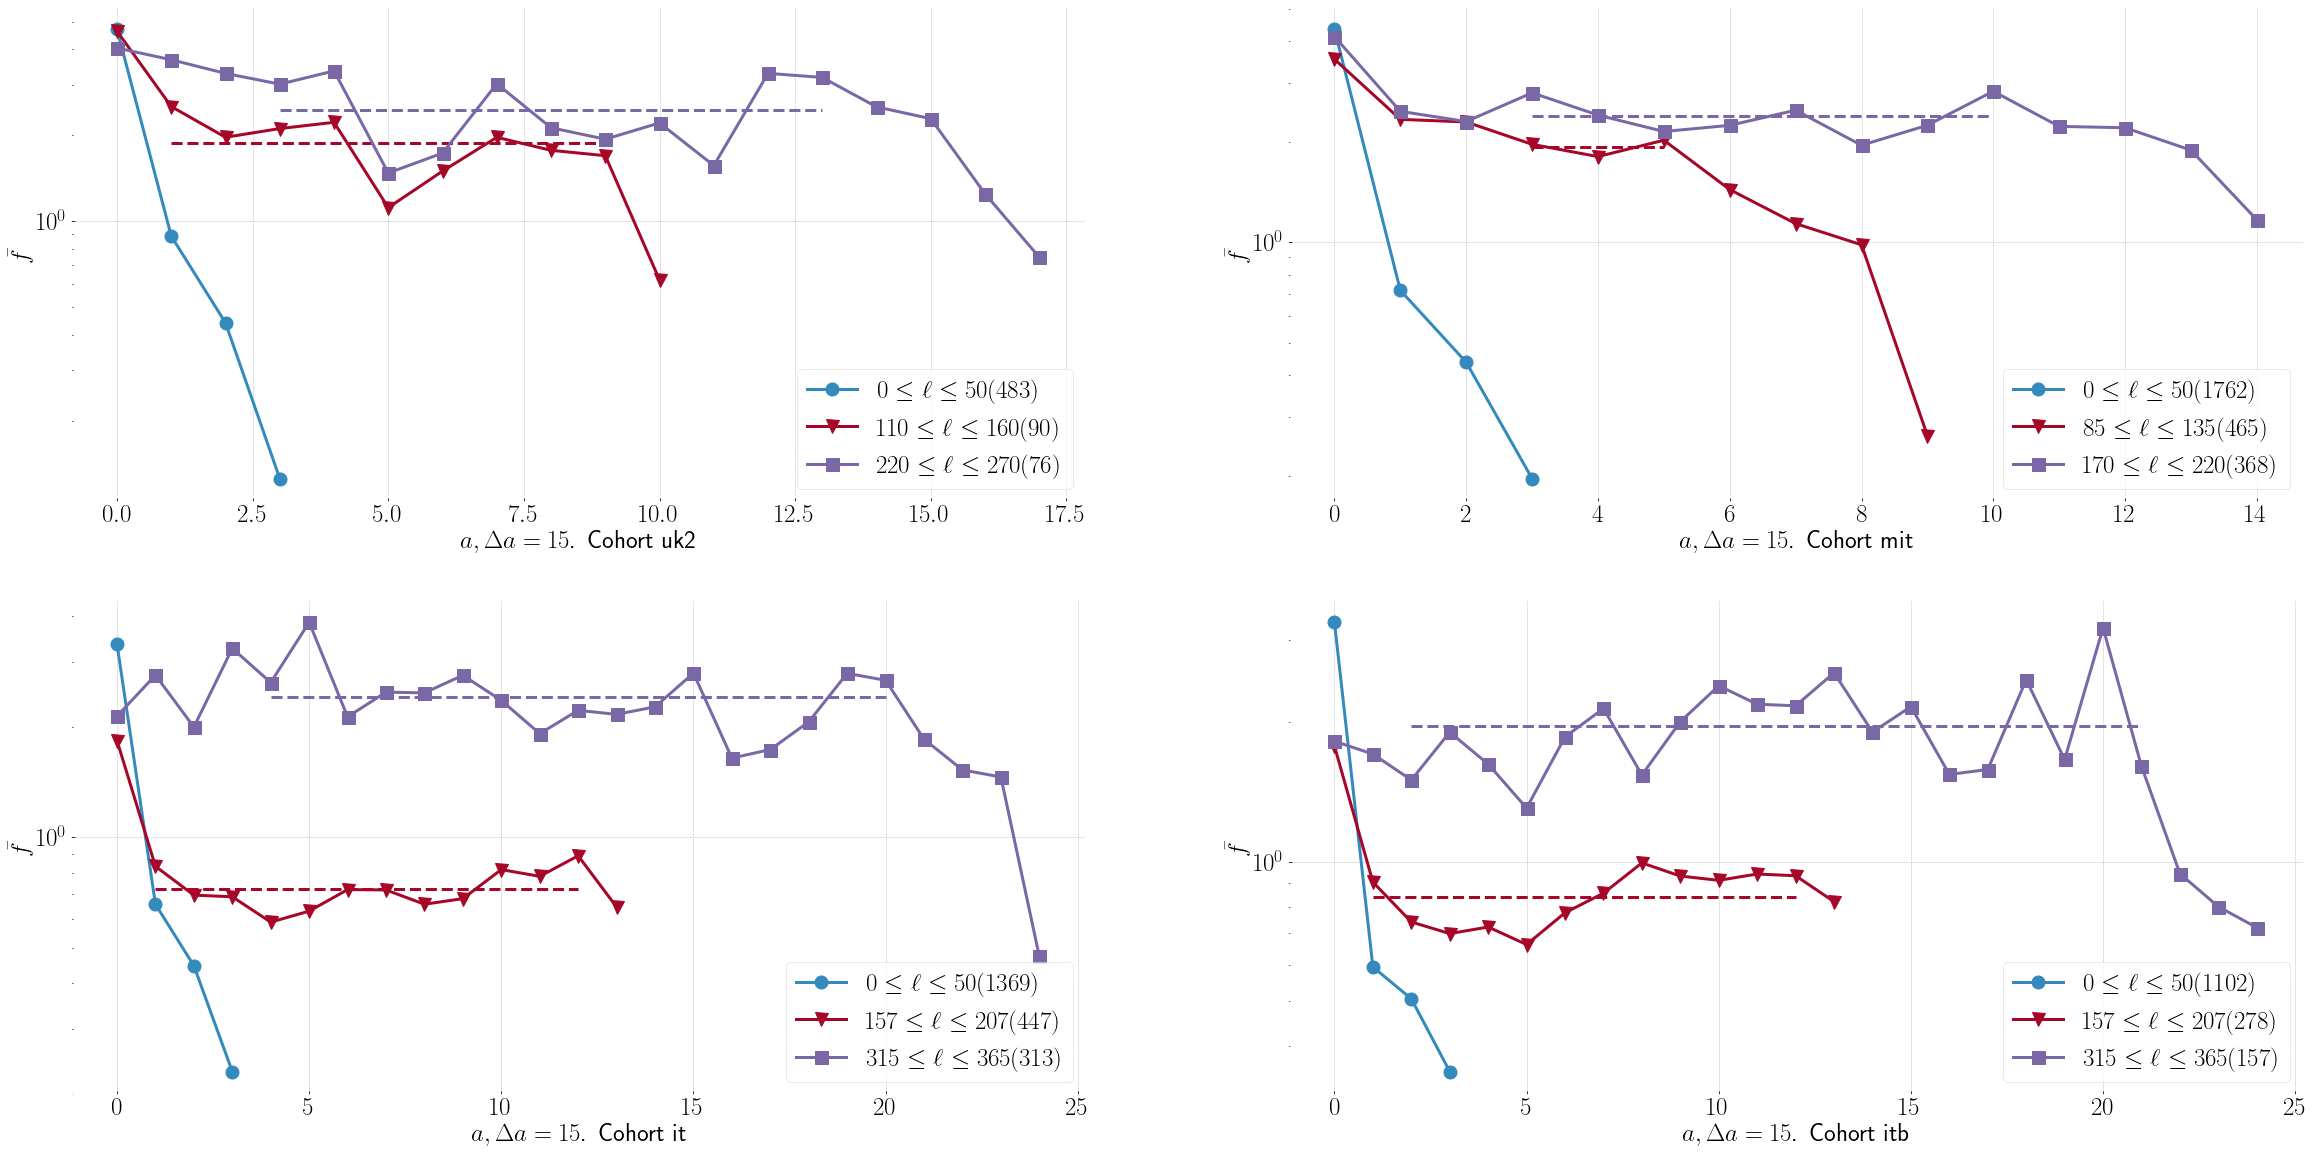

In [135]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk2', 'mit', 'it', 'itb']:
    plt.subplot(2, 2, p)
    #plt.ylim(10**(-1), 10**1)
    plt.semilogy()
    #plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]} ({fig1[c][i]["nalters"]})$')
        if i > 0:
            plt.plot(dashed[c][i][0], dashed[c][i][1], marker="", ls="--", lw=3, c=colors[i])
    plt.legend()
    p += 1
# plt.savefig("/home/vsvh/Desktop/B.png", dpi=200, pad_inches=2)

In [136]:
# for c in fig1.keys():
#     tmp = pd.DataFrame()
#     for l in fig1[c].keys():
#         df = fig1[c][l]['f']
#         df.columns = [f'l{int(l)}']
#         if len(tmp) == 0:
#             tmp = tmp.append(df)
#         else:
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#     tmp.index.rename('a', inplace=True)
#     tmp.fillna('nan', inplace=True)
#     tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig1_{c}.dat", header=True, sep="\t")

# Fig 2

In [137]:
ksp = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

In [138]:
tmp = pd.DataFrame(index=range(111))
lists = []
for c in ksp.keys():
    for k in ['m', 'l']:
        thelist = ksp[c][k]
        lists.append(thelist)
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{k}'] = thelist[i]

In [139]:
for c in ksp.keys():
    for k in ksp[c].keys():
        lista = ksp[c][k]
        count = 0
        for i in lista:
            if i < 0.05:
                count += 1
        print(c, k, count/len(lista))

uk2 m 0.0
uk2 l 0.041666666666666664
itb m 0.009708737864077669
itb l 0.0
it m 0.00847457627118644
it l 0.02247191011235955
mit m 0.0
mit l 0.0


In [140]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2.dat", index=False, header=True, sep="\t")

In [141]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

In [142]:
bhist = {}
for c in fig1.keys():
    bhist[c] = {}
    for lamb in fig1[c].keys():
        bhist[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve = fig1[c][lamb]['fi'][ego]
            if len(curve > 1):
                b = pc.get_b_slopes(curve)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist[c][lamb].append(b[1][1])

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:794: RuntimeWarning: invalid value encountered in double_scalars


In [143]:
cols = {1: 'm', 2: 'l'}
tmp = pd.DataFrame(index=range(111))
lists = []
for c in bhist.keys():
    for ell in [1, 2]:
        thelist = bhist[c][ell]
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{cols[ell]}'] = thelist[i]
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2down.dat", index=False, header=True, sep="\t")

In [144]:
cols = ['uk2m', 'itbm', 'itm', 'mitm', 'uk2l', 'itbl', 'itl', 'mitl']
pos = [0,3,6,9,1,4,7,10]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    sd = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'sd'] = sd
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 4]
b = tmp2.loc[tmp2.index >= 4]
# a.to_csv("../commpatterns/PNAS_paper/figs/fig2bmdown.dat", index=True, header=True, sep="\t")
# b.to_csv("../commpatterns/PNAS_paper/figs/fig2bldown.dat", index=True, header=True, sep="\t")

In [145]:
a

c  pos      mean        sd
idx                               
0    uk2m    0  1.828679  2.067718
1    itbm    3  0.937586  0.592817
2     itm    6  0.849453  0.594481
3    mitm    9  1.804945  2.665293

In [146]:
dashed

{'uk2': {0: [[1, 2], [0.663175464631242, 0.663175464631242]],
  1: [[1, 9], [1.87373430853823, 1.87373430853823]],
  2: [[3, 13], [2.448535988086695, 2.448535988086695]]},
 'itb': {0: [[1, 2], [0.5495548728469455, 0.5495548728469455]],
  1: [[1, 12], [0.8390481094780258, 0.8390481094780258]],
  2: [[2, 21], [1.9626562663754517, 1.9626562663754517]]},
 'it': {0: [[1, 2], [0.551795638030544, 0.551795638030544]],
  1: [[1, 12], [0.7250957211167651, 0.7250957211167651]],
  2: [[4, 20], [2.410915817340646, 2.410915817340646]]},
 'mit': {0: [[1, 2], [0.5771955575112895, 0.5771955575112895]],
  1: [[3, 5], [1.9294791026572071, 1.9294791026572071]],
  2: [[3, 10], [2.3867677753542225, 2.3867677753542225]]}}

# Fig 3 with resampling

In [149]:
calls['all'] = pd.DataFrame()
for c in ['uk2', 'it', 'mit']:
    calls['all'] = calls['all'].append(calls[c])

In [150]:
len(calls['all']) == len(calls['uk2']) + len(calls['mit']) + len(calls['it'])

True

In [152]:
fig3b = {}
for c in ['all', 'uk2', 'itb', 'it', 'mit']:
    fig3b[c] = pc.get_survival2(calls[c], 30, 60, maxell = 220, base = 3)

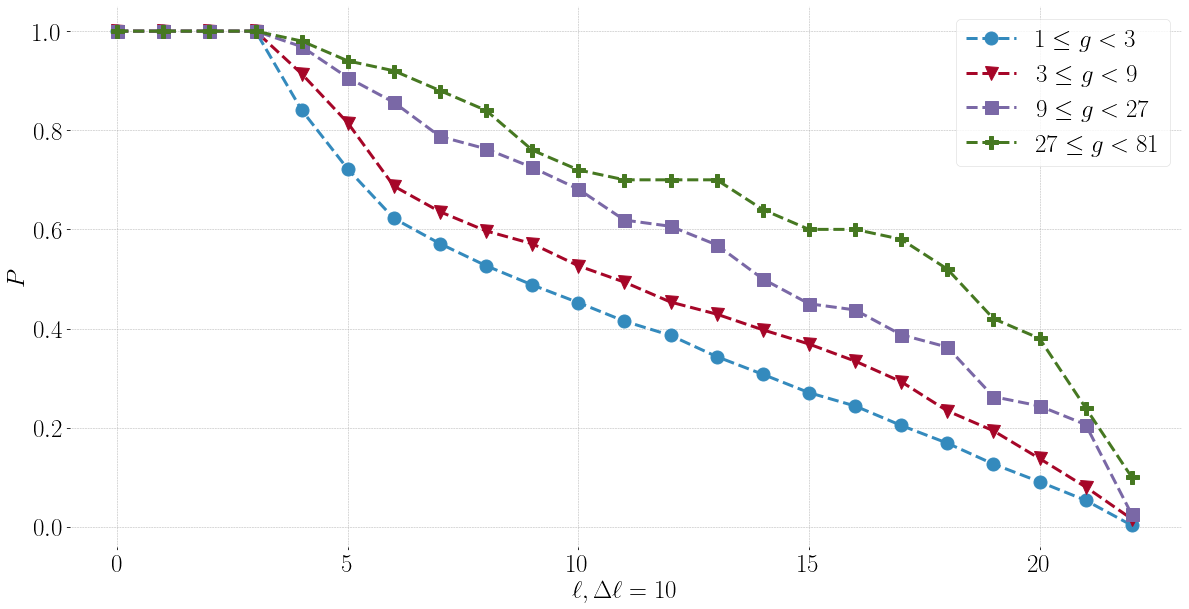

In [155]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(4):
    plt.plot(fig3b['all'][i].index, fig3b['all'][i]['p'], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${3**i} \leq g < {3**(i + 1)}$')
plt.legend()

In [156]:
tmp = pd.DataFrame({'lc': list(fig3b['all'][0].index)})
for s in range(4):
    df = fig3b['all'][s]
    tmp[f'p{int(s)}'] = df['p']
# tmp.to_csv(f'../commpatterns/PNAS_paper/figs/allsurvival.dat', header=True, index=False, sep="\t")

# Fig 4 with resampling

In [157]:
callsUM = pd.DataFrame()
for c in ['uk2', 'mit']:
    callsUM = callsUM.append(calls[c])
    
surv_cont = pc.get_survival2(callsUM, 30, 60, maxell=220, base = 3)

In [158]:
tmp = pd.DataFrame()
for s in range(4):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 3**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/figs/contour.dat", header=False, index=False, sep="\t")

In [159]:
points_it = pc.get_survival2(calls['it'], 30, 60, binned=False, maxell=220)

tmp = pd.DataFrame()
for s in points_it.keys():
    if s < 3**4 + 1:
        df = points_it[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
# p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/figs/points{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)


# SI with resampling

## Using different values for $\Delta t_w$

In [160]:
t0 = dt.datetime.now()
S1 = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    S1[c] = {}
    if c != 'itb':
        df = unfiltered[c].copy(deep=True)
        df['ea'] = list(zip(df['ego'], df['alter']))
        lf = df.groupby('ea')[['aclock']].max()
        keep = lf.loc[lf['aclock'] <= L[c]]
        df = df[df['ea'].isin(keep.index)]
    else:
        df = unfiltered['it'].copy(deep=True)
        df['ea'] = list(zip(df['ego'], df['alter']))
        lf = df.groupby('ea')[['aclock']].max()
        keep = lf.loc[lf['aclock'] <= 365]
        df = df[df['ea'].isin(keep.index)]
        t0i = df.groupby('ego')['uclock'].min()
        t0x = df.groupby('ea')[['uclock']].min()
        t0x['dif'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
        keep = t0x.loc[t0x['dif'] > 50]
        df = df[df['ea'].isin(keep.index)]
    for tw in [10, 30, 50, 60, 90]:
        S1[c][tw] = {}
        cdf = pc.apply_filters(df, tw)
        for lamb in range(3):
            S1[c][tw][lamb] = pc.get_fal(cdf, limits[c][lamb][0], limits[c][lamb][1], 15)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:12.765140


In [161]:
plt.figure(figsize=(12*4, 8*6))
p = 1
for Dt in S1['uk2'].keys():
    for c in S1.keys():
        plt.subplot(6, 4, p)
        plt.xlabel(fr"$\ell, \Delta \ell = 50$. Cohort {c}")
        plt.ylabel(fr'$\bar{{f}}, \Delta t_w = {Dt}$')
        plt.semilogy()
        for lamb in range(3):
            plt.plot(S1[c][Dt][lamb]['f'].index, S1[c][Dt][lamb]['f']['f'], marker="o", markersize=12, ls="dashed", lw=3, label=fr'${limits[c][lamb][0]}\leq \ell \leq {limits[c][lamb][1]}$')
        plt.legend()
        p += 1

In [162]:
tmp = pd.DataFrame(index=list(range(25)))
for c in S1.keys():
    for Dt in S1[c].keys():
        for i in range(3):
            idx = list(S1[c][Dt][i]['f'].index)
            series = list(S1[c][Dt][i]['f']['f'])
            colname = f'{c}{Dt}{["s", "m", "l"][i]}'
            df = pd.DataFrame({colname: series}, index=idx)
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
# tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S1.dat", header=True, index=True, sep="\t")

## Different values for $\Delta \ell$

In [163]:
limits

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'itb': [(0, 50), (157, 207), (315, 365)],
 'it': [(0, 50), (157, 207), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

In [164]:
lims = {}
for c in limits.keys():
    lims[c] = {}
    for i in range(3):
        lims[c][i] = [limits[c][i]] + [(limits[c][i][0], limits[c][i][0] + Dl) for Dl in [10, 30, 70, 90]]
        
lims

{'uk2': {0: [(0, 50), (0, 10), (0, 30), (0, 70), (0, 90)],
  1: [(110, 160), (110, 120), (110, 140), (110, 180), (110, 200)],
  2: [(220, 270), (220, 230), (220, 250), (220, 290), (220, 310)]},
 'itb': {0: [(0, 50), (0, 10), (0, 30), (0, 70), (0, 90)],
  1: [(157, 207), (157, 167), (157, 187), (157, 227), (157, 247)],
  2: [(315, 365), (315, 325), (315, 345), (315, 385), (315, 405)]},
 'it': {0: [(0, 50), (0, 10), (0, 30), (0, 70), (0, 90)],
  1: [(157, 207), (157, 167), (157, 187), (157, 227), (157, 247)],
  2: [(315, 365), (315, 325), (315, 345), (315, 385), (315, 405)]},
 'mit': {0: [(0, 50), (0, 10), (0, 30), (0, 70), (0, 90)],
  1: [(85, 135), (85, 95), (85, 115), (85, 155), (85, 175)],
  2: [(170, 220), (170, 180), (170, 200), (170, 240), (170, 260)]}}

In [165]:
S2 = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    S2[c] = {}
    for i in range(3):
        S2[c][i] = {}
        for j in range(5):
            S2[c][i][j] = pc.get_fal(calls[c], lims[c][i][j][0], lims[c][i][j][1], 15)

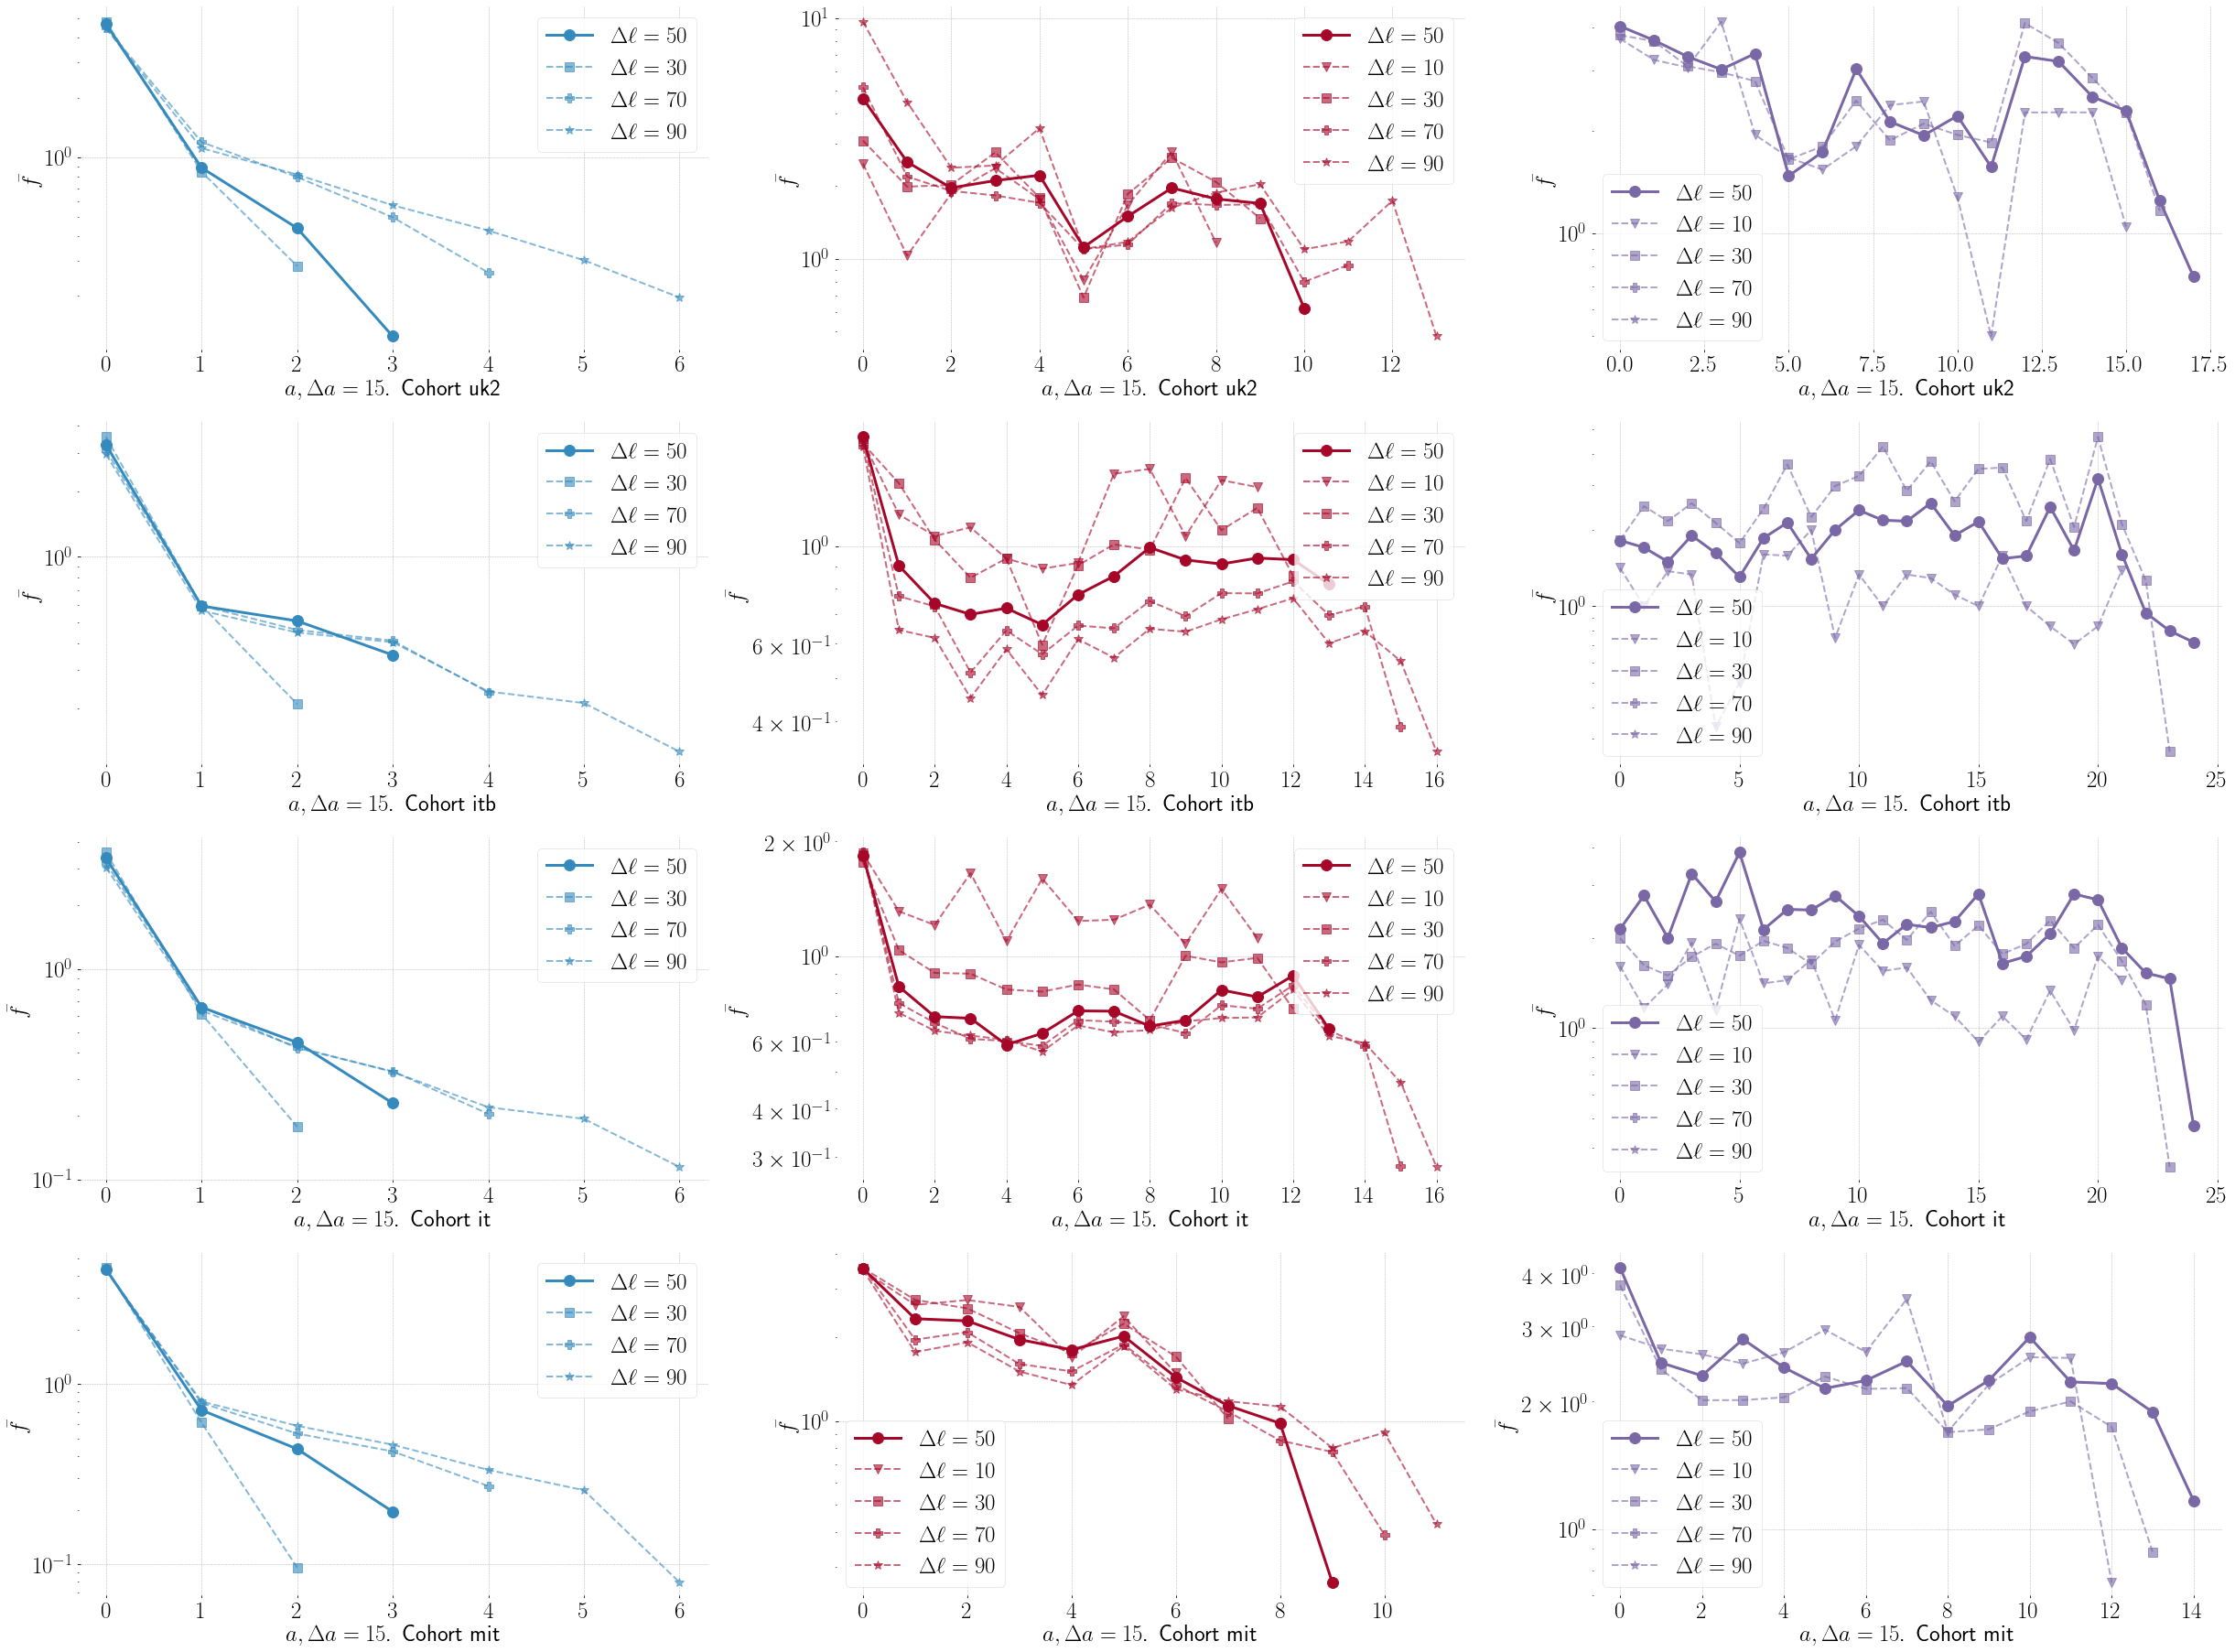

In [166]:
plt.figure(figsize=(14*3, 8*4))
p = 1
for c in S2.keys():
    for lg in S2[c].keys():
        plt.subplot(4, 3, p)
        plt.xlabel(fr"$a, \Delta a  = 15$. Cohort {c}")
        plt.ylabel(r"$\bar{f}$")
        plt.semilogy()
        plt.plot(S2[c][lg][0]['f'].index, S2[c][lg][0]['f']['f'], marker="o", markersize=12, ls="solid", lw=3, c=colors[lg], label=r'$\Delta \ell = 50$')
        for i in range(1, 5):
            if S2[c][lg][i] is not None:
                plt.plot(S2[c][lg][i]['f'].index, S2[c][lg][i]['f']['f'], marker=markers[i], markersize=10, ls="dashed", lw=2, c=colors[lg], alpha=0.6, label=fr'$\Delta \ell = {[10, 30, 70, 90][i - 1]}$')
        plt.legend()
        p += 1

In [167]:
tmp = pd.DataFrame(index=list(range(28)))
for c in S2.keys():
    for lg in S2[c].keys():
        for i in range(5):
            df = S2[c][lg][i]
            if df is not None:
                df = df['f']
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                series = list(df['f'])
                df2 = pd.DataFrame({colname: series}, index=df.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
            else:
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                df2 = pd.DataFrame({colname: [np.nan  for x in range(28)]}, index=tmp.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S2.dat", header=True, index=True, sep="\t")

## Fig 1: variations of $\Delta a$

In [168]:
t0 = dt.datetime.now()
Deltaa = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    Deltaa[c] = {}
    for Da in [5, 10, 15, 30, 45]:
        Deltaa[c][Da] = {}
        for i in range(3):
            Deltaa[c][Da][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], Da)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:11.047784


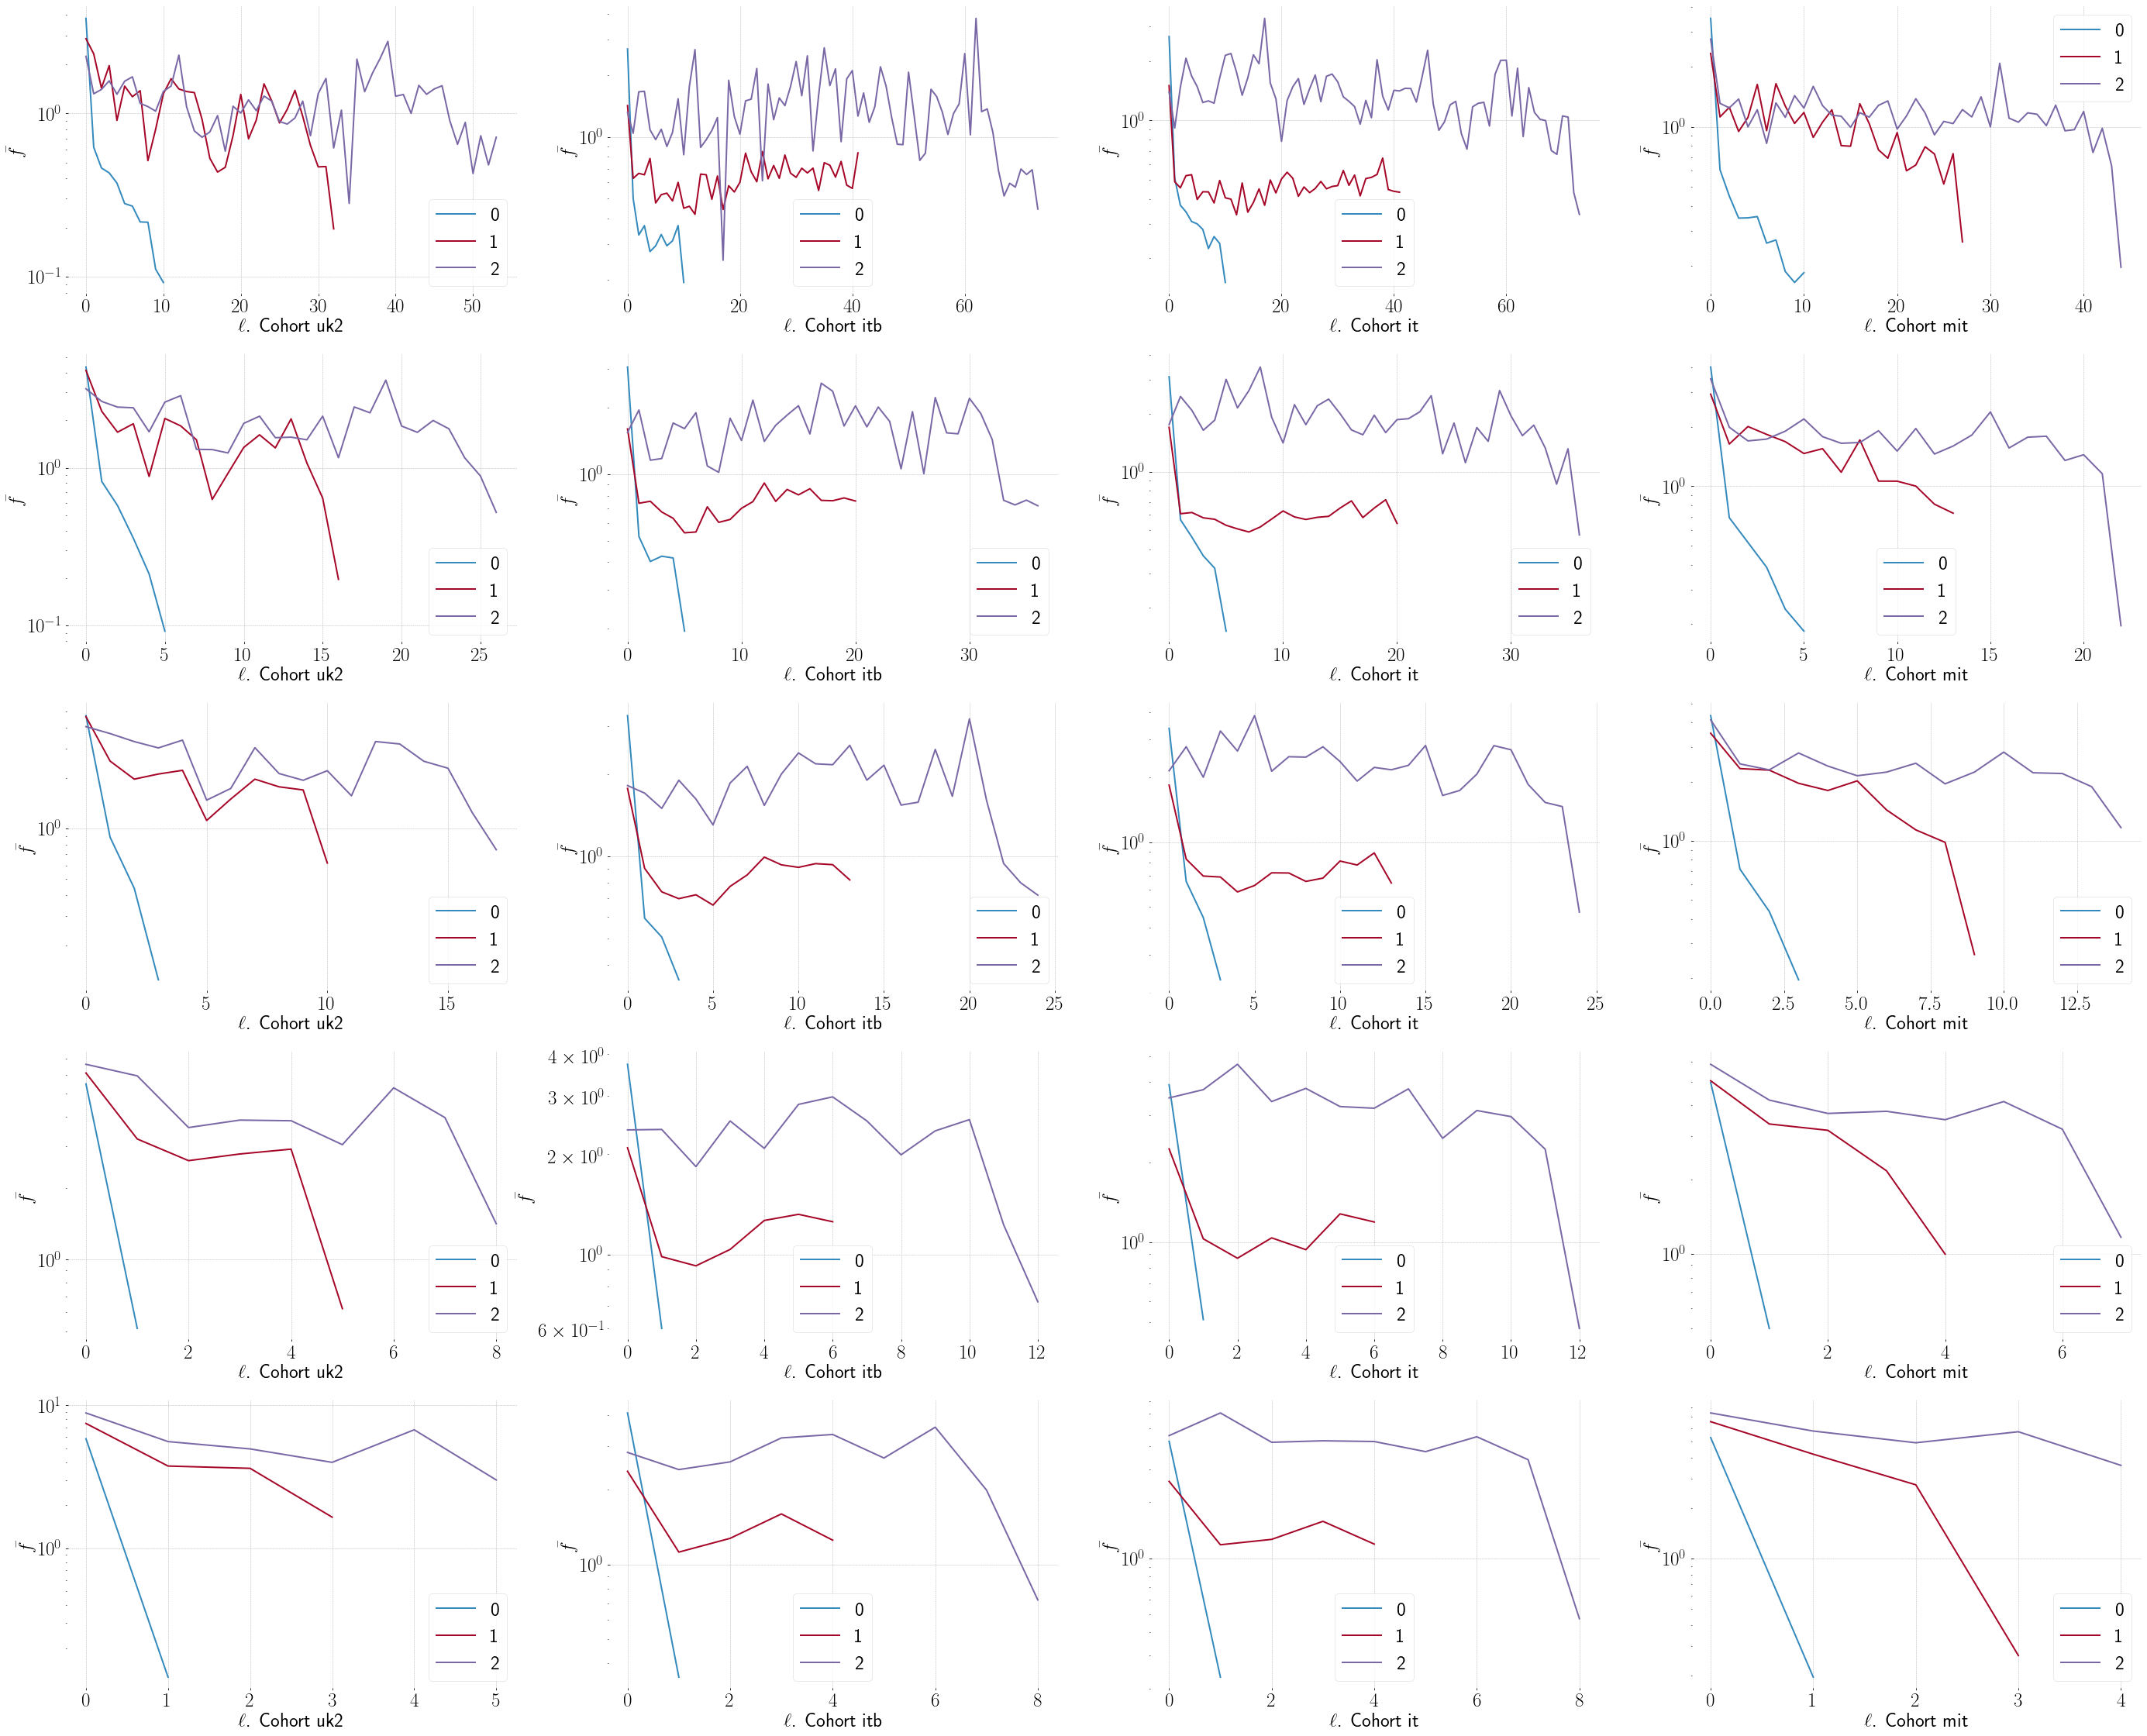

In [169]:
plt.figure(figsize=(12*4, 8*5))
p = 1
for Da in [5, 10, 15, 30, 45]:
    for c in ['uk2', 'itb', 'it', 'mit']:
        plt.subplot(5,4,p)
        plt.xlabel(fr'$\ell$. Cohort {c}')
        plt.ylabel(r'$\bar{f}$')
        plt.semilogy()
        for i in range(3):
            plt.plot(Deltaa[c][Da][i]['f'].index, Deltaa[c][Da][i]['f']['f'], label=f'{i}')
        plt.legend()
        p += 1

In [170]:
tmp = pd.DataFrame(index=range(60))
for c in Deltaa.keys():
    for Da in Deltaa[c].keys():
        for i in range(3):
            df = Deltaa[c][Da][i]['f']
            df.index *= Da
            df = df.reset_index()
            if c != 'uk2':
                df.columns = [f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            else:
                df.columns = [f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')

# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S2.5.dat", index=False, sep="\t", header=True)

## Variations on $\Delta t_s$ for IT${}_n$

In [171]:
time0 = dt.datetime.now()
Deltats = {}
for ts in range(10, 61, 10):
    # No Filter
    df = unfiltered['it'].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    # L
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= 365]
    df = df[df['ea'].isin(keep.index)]
    # Delta t to the left (by ego)
    t0i = df.groupby('ego')['uclock'].min()
    t0x = df.groupby('ea')[['uclock']].min()
    t0x['dif'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
    keep = t0x.loc[t0x['dif'] > ts]
    df = df[df['ea'].isin(keep.index)]
    # Delta t to the right
    df = pc.apply_filters(df, 60)
    Deltats[ts] = {}
    for i in range(3):
        Deltats[ts][i] = pc.get_fal(df, limits['itb'][i][0], limits['itb'][i][1], 15)
print(f'Took {dt.datetime.now() - time0}')

Took 0:00:05.273670


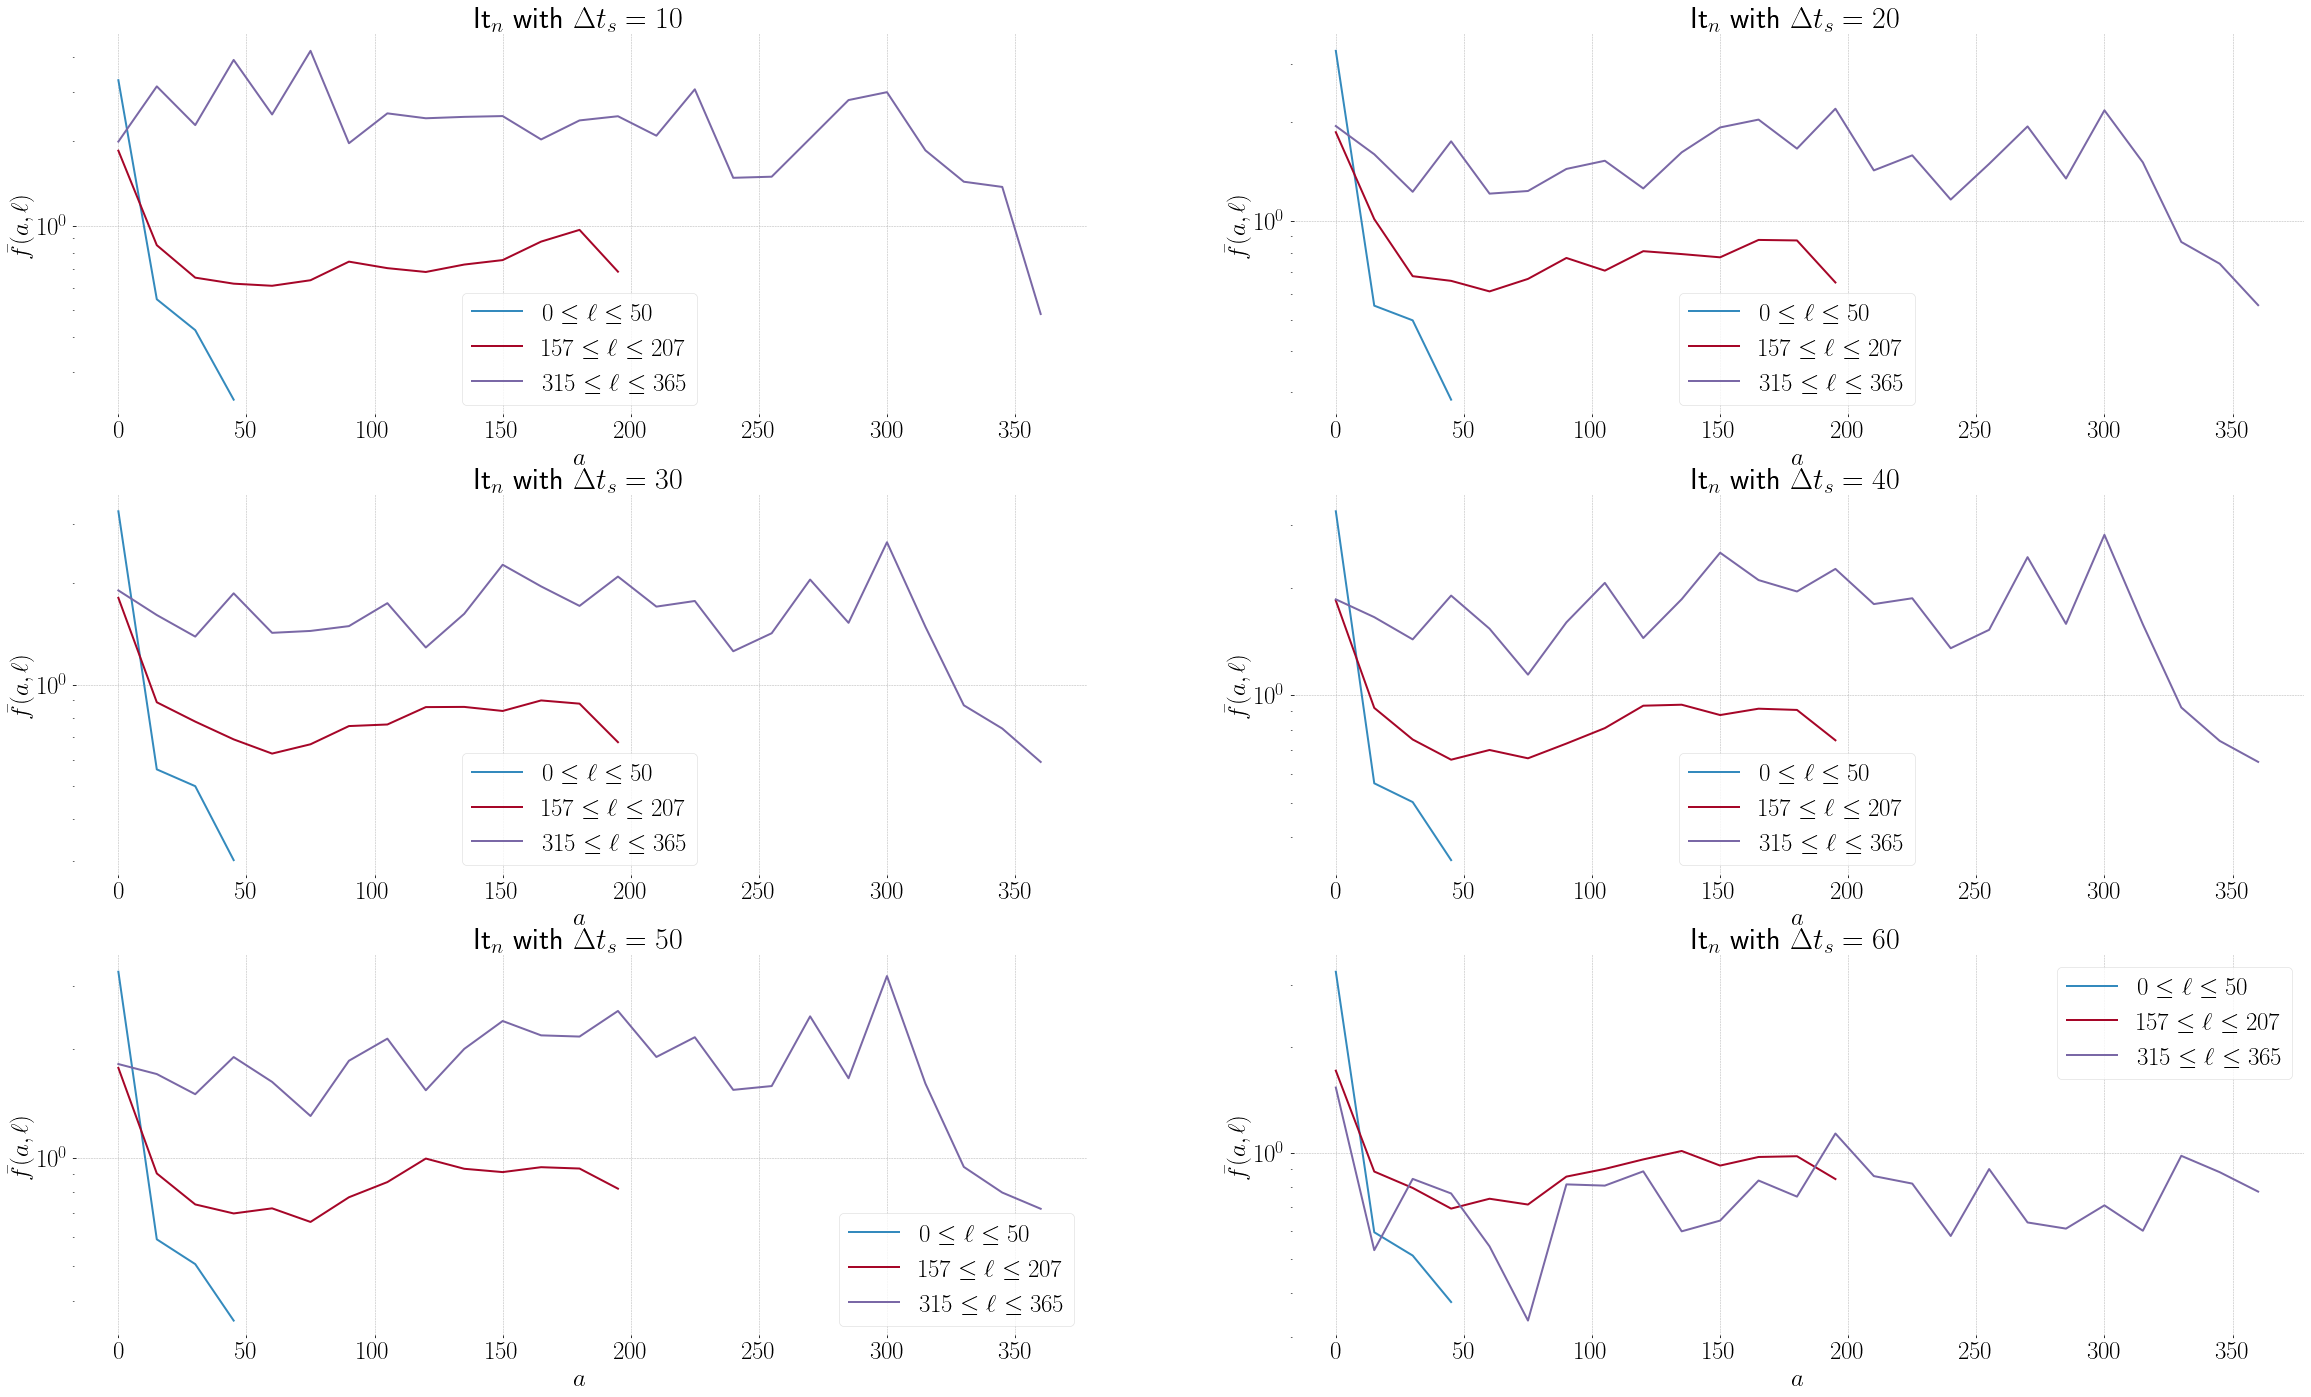

In [172]:
plt.figure(figsize=(20*2, 8*3))
p = 1
for ts in Deltats.keys():
    plt.subplot(3,2,p)
    plt.title(fr'It${{}}_n$ with $\Delta t_s = {ts}$')
    plt.xlabel(r"$a$")
    plt.ylabel(r"$\bar{f}(a, \ell)$")
    plt.semilogy()
    for i in range(3):
        plt.plot([x * 15 for x in Deltats[ts][i]['f'].index], Deltats[ts][i]['f']['f'], label=fr'${limits["itb"][i][0]} \leq \ell \leq {limits["itb"][i][1]}$')
    plt.legend()
    p += 1
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/Deltats.pdf", dpi=150)

In [173]:
tmp = pd.DataFrame()
for ts in Deltats.keys():
    for i in range(3):
        df = Deltats[ts][i]['f'].copy(deep=True)
        df.columns = [f'y{ts}{i}']
        df[f'x{ts}{i}'] = df.index
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S2.6.dat", index=False, header=True, sep="\t")

## $\bar{f}$ with a random sample of $\bar{f_{i}}$
For all cohorts

In [174]:
useegos = []
for e in fig1['mit'][2]['fi'].keys():
    if len(fig1['mit'][2]['fi'][e].index) >= 10:
        useegos.append(e)

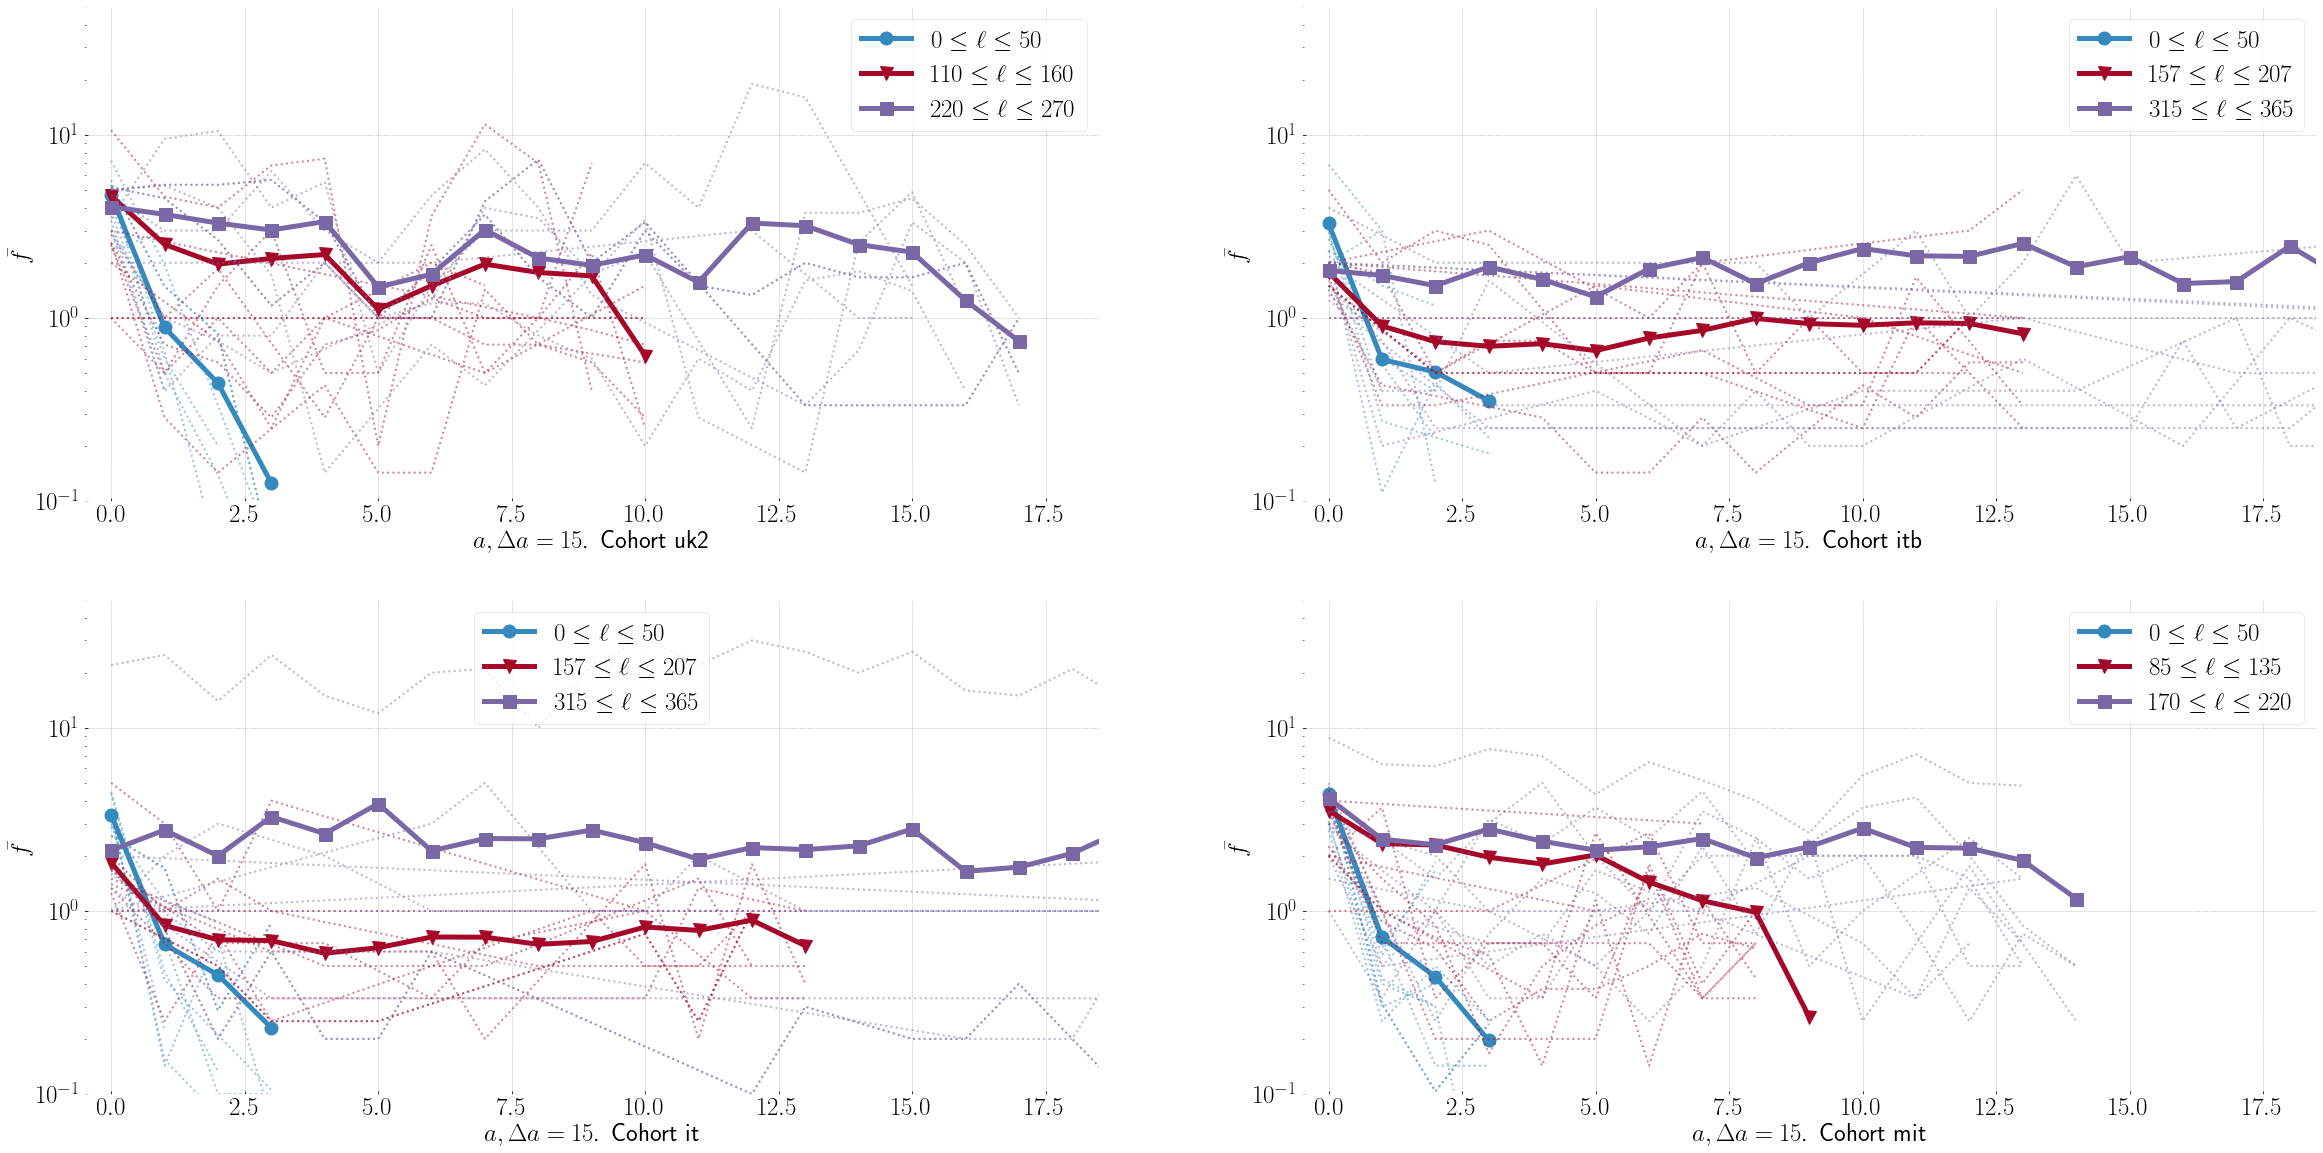

In [178]:
np.random.seed(698)
tmp = pd.DataFrame(index=range(18))
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk2', 'itb', 'it', 'mit']:
    plt.subplot(2,2, p)
    plt.ylim(10**(-1), 5*10**1)
    plt.semilogy()
    plt.xlim(-0.5, 18.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=5, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]}$')
        df = fig1[c][i]['f'].copy(deep=True)
        df.columns = [f'{c}{i}avg']
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
        if c != 'sss':
            egos = np.random.choice(list(fig1[c][i]['fi'].keys()), size=10)
        else:
            egos = np.random.choice(useegos, size=10)
        en = 1
        for e in egos:
            plt.plot(fig1[c][i]['fi'][e].index, fig1[c][i]['fi'][e]['f'], marker="", ls="dotted", lw=2, c=colors[i], alpha=0.5)
            df = fig1[c][i]['fi'][e].copy(deep=True)
            df.columns = [f'{c}{i}e{en}']
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            en += 1
    plt.legend()
    p += 1
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA.pdf", dpi=200)

In [179]:
# tmp = tmp.fillna('nan')
# tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S3.dat", header=True, index=True, sep="\t")

In [ ]:
tmp

## $b(\ell)$ by cohort

Only when it converges. I may try to  bin the values of $b$ to make it smoother. Also, I will calculate the same measurement considering a combined cohort.

In [ ]:
# dffcomb['all'] = {}
# for c in ['uk1', 'uk2', 'it1', 'it2', 'mit']:
#     dffcomb['all'].update(dffcomb[c])

In [184]:
t0 = dt.datetime.now()
b = {}
b2 = {}
converge = {}
converge2 = {}
nalt = {}
nego = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    b[c] = {}
    b2[c] = {}
    converge[c] = {}
    converge2[c] = {}
    nalt[c] = {}
    nego[c] = {}
    for ell in range(366):
        curve = pc.get_fal(calls[c], ell, ell + 50, 15, countalters=True)
        if (curve is not None) and (len(curve['f']) > 2):
            points = pc.get_b_slopes(curve['f'], FlagConverge=True)
            points2 = pc.get_b_mk(curve['f'], FlagConverge=True)
            b[c][ell] = points[1][1]
            b2[c][ell] = points2[1][1]
            converge[c][ell] = points[2]
            converge2[c][ell] = points2[2]
            nalt[c][ell] = curve['nalters']
            nego[c][ell] = curve['egocount']
    b[c] = pd.DataFrame.from_dict(b[c], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
    tmpb2 = pd.DataFrame.from_dict(b2[c], orient='index').sort_index().rename({0: 'mk'}, axis='columns')
    tmp = pd.DataFrame.from_dict(converge[c], orient="index").sort_index().rename({0: 'convs'}, axis='columns')
    tmpc2 = pd.DataFrame.from_dict(converge2[c], orient="index").sort_index().rename({0: 'convm'}, axis='columns')
    tmp2 = pd.DataFrame.from_dict(nalt[c], orient="index").sort_index().rename({0: 'nalt'}, axis='columns')
    tmp3 = pd.DataFrame.from_dict(nego[c], orient="index").sort_index().rename({0: 'nego'}, axis='columns')
    b[c] = b[c].merge(tmpb2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmpc2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp3, left_index=True, right_index=True, how='outer')
    b[c]['mas'] = b[c]['slopes'].rolling(window=50).mean()
    b[c]['mam'] = b[c]['mk'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:03:40.979453


In [185]:
for c in b.keys():
    print(c, b[c]['convs'].mean())

uk2 0.5613382899628253
itb 0.8907103825136612
it 0.855191256830601
mit 0.6334841628959276


In [186]:
plt.figure(figsize=(20*1, 10*2))
plt.subplot(211)
plt.semilogy()
plt.xlabel(r"Alter lifetime")
plt.ylabel(r"$b(\ell)$ using stable average")
for c in ['uk2', 'itb', 'it', 'mit']:
    df = b[c].loc[b[c]['convs'] == True]
    if c != 'all':
        plt.plot(df.index, df['slopes'], label=c)
    else:
        plt.plot(df.index, df['slopes'], ls = "dashed", c="black", lw=4, label=c)
plt.legend()

plt.subplot(212)
plt.semilogy()
plt.xlabel(r"Alter lifetime")
plt.ylabel(r"$b(\ell)$ using Mann Kendall")
for c in ['uk2', 'itb', 'it', 'mit']:
    df = b[c].loc[b[c]['convs'] == True]
    if c != 'all':
        plt.plot(df.index, df['mk'], label=c)
    else:
        plt.plot(df.index, df['mk'], ls = "dashed", c="black", lw=4, label=c)
plt.legend()

In [187]:
binsize = 50
bbins = {}
for c in b.keys():
    df = b[c].loc[b[c]['convs'] == True]
    df2 = df[['slopes', 'mk']].copy()
    df2['lambda'] = df.index.map(lambda x: x // binsize)
    bbins[c] = df2.groupby('lambda').mean()
    bbins[c]['x'] = bbins[c].index.map(lambda x: (x * binsize) + (binsize // 2))

In [188]:
plt.figure(figsize=(20*1, 10*2))
plt.subplot(211)
plt.semilogy()
# plt.xlim(30, 370)
plt.xlabel(r"Alter lifetime")
plt.ylabel(r"$b(\ell)$ using stable average")
m = -1
for c in ['uk2', 'itb', 'it', 'mit']:
    if c != 'all':
        m += 1
        plt.plot(bbins[c]['x'], bbins[c]['slopes'], marker=markers[m], markersize=15, ls="solid", lw=3, 
                 c=colors[m], label=c)
    else:
        plt.plot(bbins[c]['x'], bbins[c]['slopes'], ls = "dashed", c="black", lw=4, label=c)
plt.legend()

plt.subplot(212)
plt.semilogy()
# plt.xlim(30, 370)
plt.xlabel(r"Alter lifetime")
plt.ylabel(r"$b(\ell)$ using Mann Kendall")
m = -1
for c in ['uk2', 'itb', 'it', 'mit']:
    if c != 'all':
        m += 1
        plt.plot(bbins[c]['x'], bbins[c]['mk'], marker=markers[m], markersize=15, ls="solid", lw=3, 
                 color=colors[m], label=c)
    else:
        plt.plot(bbins[c]['x'], bbins[c]['mk'], ls = "dashed", c="black", lw=4, label=c)
plt.legend()

In [189]:
tmp = pd.DataFrame()
for c in bbins.keys():
    # df = bbins[c].loc[bbins[c]['x'] < 350]
    df = bbins[c].copy(deep=True)
    df.columns = [f's{c}', f'm{c}', f'x{c}']
    tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
    
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S4.dat", index=False, header=True, sep="\t")

In [ ]:
tmp

## Distribution of $b_i(\ell)$

In [190]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

In [191]:
tmp = pd.DataFrame()
for c in bhist.keys():
    print(f'====================={c}========================')
    for lamb in range(3):
        H = histogram(bhist[c][lamb], 10, log=False)
        # print(c, len(H))
        # H['tmp'] = H['h'] * H['label']
        # avg = sum(H['tmp']) / sum(H['h'])
        avg = np.mean(bhist[c][lamb])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.001) ({avg}, 1)}};")
        H = H[['pmf', 'label']]
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')

=====================uk2========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.6601629544084787, 0.001) (0.6601629544084787, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(1.8286789428415045, 0.001) (1.8286789428415045, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(2.264014332228618, 0.001) (2.264014332228618, 1)};
=====================itb========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.5944399064326428, 0.001) (0.5944399064326428, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.9375855477034395, 0.001) (0.9375855477034395, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.1258008182855719, 0.001) (1.1258008182855719, 1)};
=====================it========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.5915763449430073, 0.001) (0.5915763449430073, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.849452966316839, 0.001) (0.

In [192]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S5.dat", index=False, header=True, sep="\t")

In [ ]:
tmp

### Now using mann kendall

In [193]:
bhist2 = {}
for c in fig1.keys():
    bhist2[c] = {}
    for lamb in fig1[c].keys():
        bhist2[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve2 = fig1[c][lamb]['fi'][ego]
            if len(curve2) > 1:
                b = pc.get_b_mk(curve2)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist2[c][lamb].append(b[1][1])

In [194]:
tmp = pd.DataFrame()
for c in bhist2.keys():
    print(f'====================={c}========================')
    for lamb in range(3):
        H = histogram(bhist2[c][lamb], 10, log=False)
        # print(c, len(H))
        # H['tmp'] = H['h'] * H['label']
        # avg = sum(H['tmp']) / sum(H['h'])
        avg = np.mean(bhist2[c][lamb])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.001) ({avg}, 1)}};")
        H = H[['pmf', 'label']]
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S5b.dat", index=False, header=True, sep="\t")

=====================uk2========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.9319691974192542, 0.001) (0.9319691974192542, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(1.7447298459613731, 0.001) (1.7447298459613731, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(2.311996264317693, 0.001) (2.311996264317693, 1)};
=====================itb========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.9627030531814191, 0.001) (0.9627030531814191, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.9919864381405387, 0.001) (0.9919864381405387, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.1823154799554227, 0.001) (1.1823154799554227, 1)};
=====================it========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.9108849552288114, 0.001) (0.9108849552288114, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.874622682759325, 0.001) (0.

## $p$-value distribution for the KS test

In [229]:
ksp = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

In [196]:
tmp = pd.DataFrame(index=range(10))
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ksp.keys():
    print(f'============\t{c.upper()}\t=================')
    plt.subplot(2,2, p)
    plt.semilogy()
    plt.xlim(0, 1)
    plt.xlabel(fr"$p$ values. Cohort {c}")
    plt.ylabel(r'$H(p)$')
    m = 0
    for s in ['m', 'l']:
        H = pc.histogram(ksp[c][s], 10, log=False)
        # print(np.mean(ksp[c][s]))
        # H['tmp'] = H['label'] * H['h']
        # print(c, len(H))
        # avg = sum(H['tmp']) / sum(H['h'])
        avg = np.mean(ksp[c][s])
        tmp[f'{c}x{s}'] = H['label']
        tmp[f'{c}y{s}'] = H['pmf']
        print(f'\\addplot[{dict({"m": "squirtle", "l": "ekans"})[s]}, dashed, line width = 4] coordinates{{({avg}, 0.001) ({avg}, 1)}};')
        plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, c=colors[m], label=f"{s} Lifetime")
        plt.axvline(avg, ls="solid", lw=4, c=colors[m])
        m += 1
    plt.legend()
    p += 1

============	UK2	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8440065681444993, 0.001) (0.8440065681444993, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.7322388314171189, 0.001) (0.7322388314171189, 1)};
============	ITB	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.9245408313369479, 0.001) (0.9245408313369479, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.9337788728121813, 0.001) (0.9337788728121813, 1)};
============	IT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8456568384534486, 0.001) (0.8456568384534486, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.8644975892151536, 0.001) (0.8644975892151536, 1)};
============	MIT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8586860670194004, 0.001) (0.8586860670194004, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.7822978588673316, 0.001) (0.7822978588673316, 1)};


In [197]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S6.dat", index=False, header=True, sep="\t")

## Identify $\ell_s$ for each cohort



In [198]:
def get_ells(bdf, col, lookforward=15):
    df = bdf[[col]].rolling(lookforward).mean()
    df2 = df.loc[df[col] == 1]
    if len(df2) > 0:
        return min(df2.index)
    else:
        return None

In [199]:
egolist = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    egolist[c] = [ego for ego in calls[c]['ego'].unique()]

In [258]:
t0 = dt.datetime.now()
bi = {}
bi2 = {}
convergei = {}
convergei2 = {}
niter = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    bi[c] = {}
    bi2[c] = {}
    convergei[c] = {}
    convergei2[c] = {}
    niter[c] = {}
    dff = pc.get_f(calls[c], 'all', 15, 10)
    for ego in dff.keys():
        bi[c][ego] = {}
        bi2[c][ego] = {}
        convergei[c][ego] = {}
        convergei2[c][ego] = {}
        niter[c][ego] = {}
        dffl = {ego: dff[ego]}
        for ell in range(301):
            curve = pc.get_avgfa(dffl, lives[c], ell, ell + 50)
            if (curve is not None) and (len(curve) > 3):
                points = pc.get_b_slopes(curve, FlagConverge=True)
                points2 = pc.get_b_mk(curve, FlagConverge=True)
                bi[c][ego][ell] = points[1][1]
                bi2[c][ego][ell] = points2[1][1]
                convergei[c][ego][ell] = points[2]
                convergei2[c][ego][ell] = points2[2]
                niter[c][ego][ell] =  points2[3]
        if len(bi[c][ego].keys()) > 0:
            bi[c][ego] = pd.DataFrame.from_dict(bi[c][ego], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
            tmp = pd.DataFrame.from_dict(convergei[c][ego], orient="index").sort_index().rename({0: 'convs'}, axis='columns')
            if ego in bi2[c].keys():
                tmpb2 = pd.DataFrame.from_dict(bi2[c][ego], orient='index').sort_index().rename({0: 'mk'}, axis='columns')
                tmpc2 = pd.DataFrame.from_dict(convergei2[c][ego], orient="index").sort_index().rename({0: 'convm'}, axis='columns')
            bi[c][ego] = bi[c][ego].merge(tmp, left_index=True, right_index=True, how='outer')
            if ego in bi2[c].keys():
                bi[c][ego] = bi[c][ego].merge(tmpb2, left_index=True, right_index=True, how='outer')
                bi[c][ego] = bi[c][ego].merge(tmpc2, left_index=True, right_index=True, how='outer')
                bi[c][ego]['mam'] = bi[c][ego]['mk'].rolling(window=50).mean()
            bi[c][ego]['mas'] = bi[c][ego]['slopes'].rolling(window=50).mean()
            
print(f'Took {dt.datetime.now() - t0}')

Took 0:08:00.558186


In [202]:
for ego in bi['mit'].keys():
    if type(bi['mit'][ego]) == pd.core.frame.DataFrame:
        print(np.mean(bi['mit'][ego]['convm']))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [259]:
bif = {}
bif['all'] = {}
for c in bi.keys():
    bif[c] = {}
    for ego in bi[c].keys():
        if type(bi[c][ego]) == pd.core.frame.DataFrame:
            bif[c][ego] = bi[c][ego]
            if c != 'itb':
                bif['all'].update(bif[c])

In [260]:
for c in ['uk2', 'itb', 'it', 'mit']:
    for ego in bif[c].keys():
        if ego not in bif['all'].keys():
            print('problem with', c, ego)
    else:
        print('success!', c)

success! uk2
success! itb
success! it
success! mit


In [261]:
ellsHs = {}
for c in bif.keys():
    ellsHs[c] = pc.histogram([get_ells(bif[c][ego], 'convs', lookforward=10) for ego in bif[c].keys() if get_ells(bif[c][ego], 'convs') is not None], 10, log=False)
    print(c, np.mean([get_ells(bif[c][ego], 'convs', lookforward=10) for ego in bif[c].keys() if get_ells(bif[c][ego], 'convs') is not None]), min([get_ells(bif[c][ego], 'convs', lookforward=10) for ego in bif[c].keys() if get_ells(bif[c][ego], 'convs') is not None]))

all 45.326388888888886 9
uk2 42.3 9
itb 56.916666666666664 9
it 49.02173913043478 9
mit 41.833333333333336 9


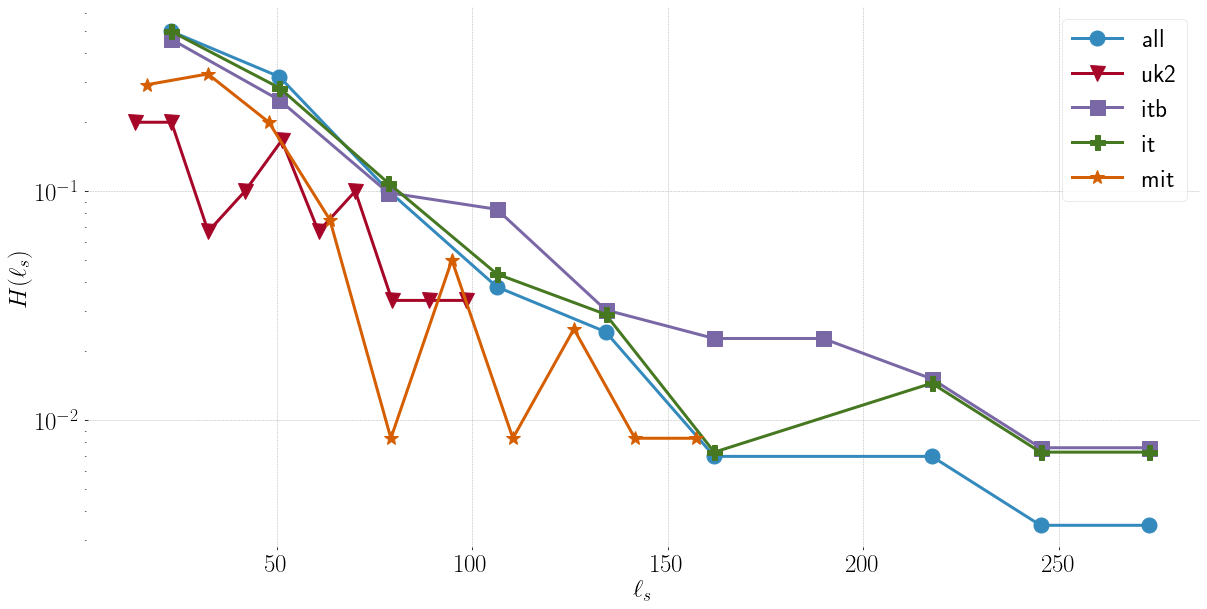

In [206]:
plt.semilogy()
plt.xlabel(r'$\ell_s$')
plt.ylabel(r'$H(\ell_s)$')
m = 0
for c in ellsHs.keys():
    plt.plot(ellsHs[c]['label'], ellsHs[c]['pmf'], marker=markers[m], ls="solid", markersize=15, lw=3, label=f'{c}')
    m += 1
plt.legend()

In [257]:
ellsHm = {}
for c in bif.keys():
    listells = [get_ells(bif[c][ego], 'convm') for ego in bif[c].keys() if get_ells(bif[c][ego], 'convm') is not None]
    if len(listells) > 0:
        ellsHm[c] = pc.histogram(listells, 10, log=False)
        print(np.mean(listells))

In [208]:
tmp = pd.DataFrame()
for c in ellsHs.keys():
    print(f'================{c}=====================')
    H = ellsHs[c].copy(deep=True)
    H['tmp'] = H['label'] * H['h']
    avg = sum(H['tmp']) / sum(H['h'])
    print(avg)
    H = H[['label', 'pmf']]
    H = H.rename({'label': f'x{c}', 'pmf': f'y{c}'}, axis='columns')
    tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S9.dat", index=False, header=True, sep="\t")

================all=====================
47.128472222222214
================uk2=====================
42.21333333333333
================itb=====================
59.12424242424243
================it=====================
50.901449275362324
================mit=====================
41.76


In [ ]:
tmp

### Estimation from a regression

In [209]:
ellsHs['all']['logp'] = np.log(ellsHs['all']['pmf'])
ellsHs['all']

h       pmf  label      logp
0  144  0.500000   22.9 -0.693147
1   91  0.315972   50.7 -1.152101
2   29  0.100694   78.5 -2.295665
3   11  0.038194  106.3 -3.265065
4    7  0.024306  134.1 -3.717050
5    2  0.006944  161.9 -4.969813
7    2  0.006944  217.5 -4.969813
8    1  0.003472  245.3 -5.662960
9    1  0.003472  273.1 -5.662960

In [210]:
Y = np.array(ellsHs['all']['logp'])
X = np.array(ellsHs['all']['label'])
X = sm.add_constant(X)

In [211]:
model = sm.OLS(Y, X)
result = model.fit()
result.summary()

/home/vsvh/.local/lib/python3.10/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     87.02
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           3.38e-05
Time:                        00:41:36   Log-Likelihood:                -6.2737
No. Observations:                   9   AIC:                             16.55
Df Residuals:                       7   BIC:                             16.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6357      0.367     -1.733      0.127      -1.503       0.232
x1            -0.0207      0.002     -9.328      0.000      -0.026      -0.015
==============================================================================
Omnibus:                        1.154   Durbin-Watson:                   1.239
Prob(Omnibus):                  0.561   Jarque-Bera (JB):                0.625
Skew:                          -0.595   Prob(JB):                        0.731
Kurtosis:                       2.498   Cond. No.                         331.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [212]:
result.params

array([-0.63570656, -0.02066745])

In [213]:
np.exp(result.params[0])

0.5295611907269471

In [214]:
-1 / result.params[1]

48.385251656895285

In [215]:
for c in bif.keys():
    thelist = [get_ells(bif[c][ego], 'convs') for ego in bif[c].keys() if get_ells(bif[c][ego], 'convs') is not None]
    print(c, np.mean(thelist), min(thelist))

all 53.0 14
uk2 51.13333333333333 14
itb 66.13636363636364 14
it 56.492753623188406 14
mit 49.45 14


## Fig 3 separated by country

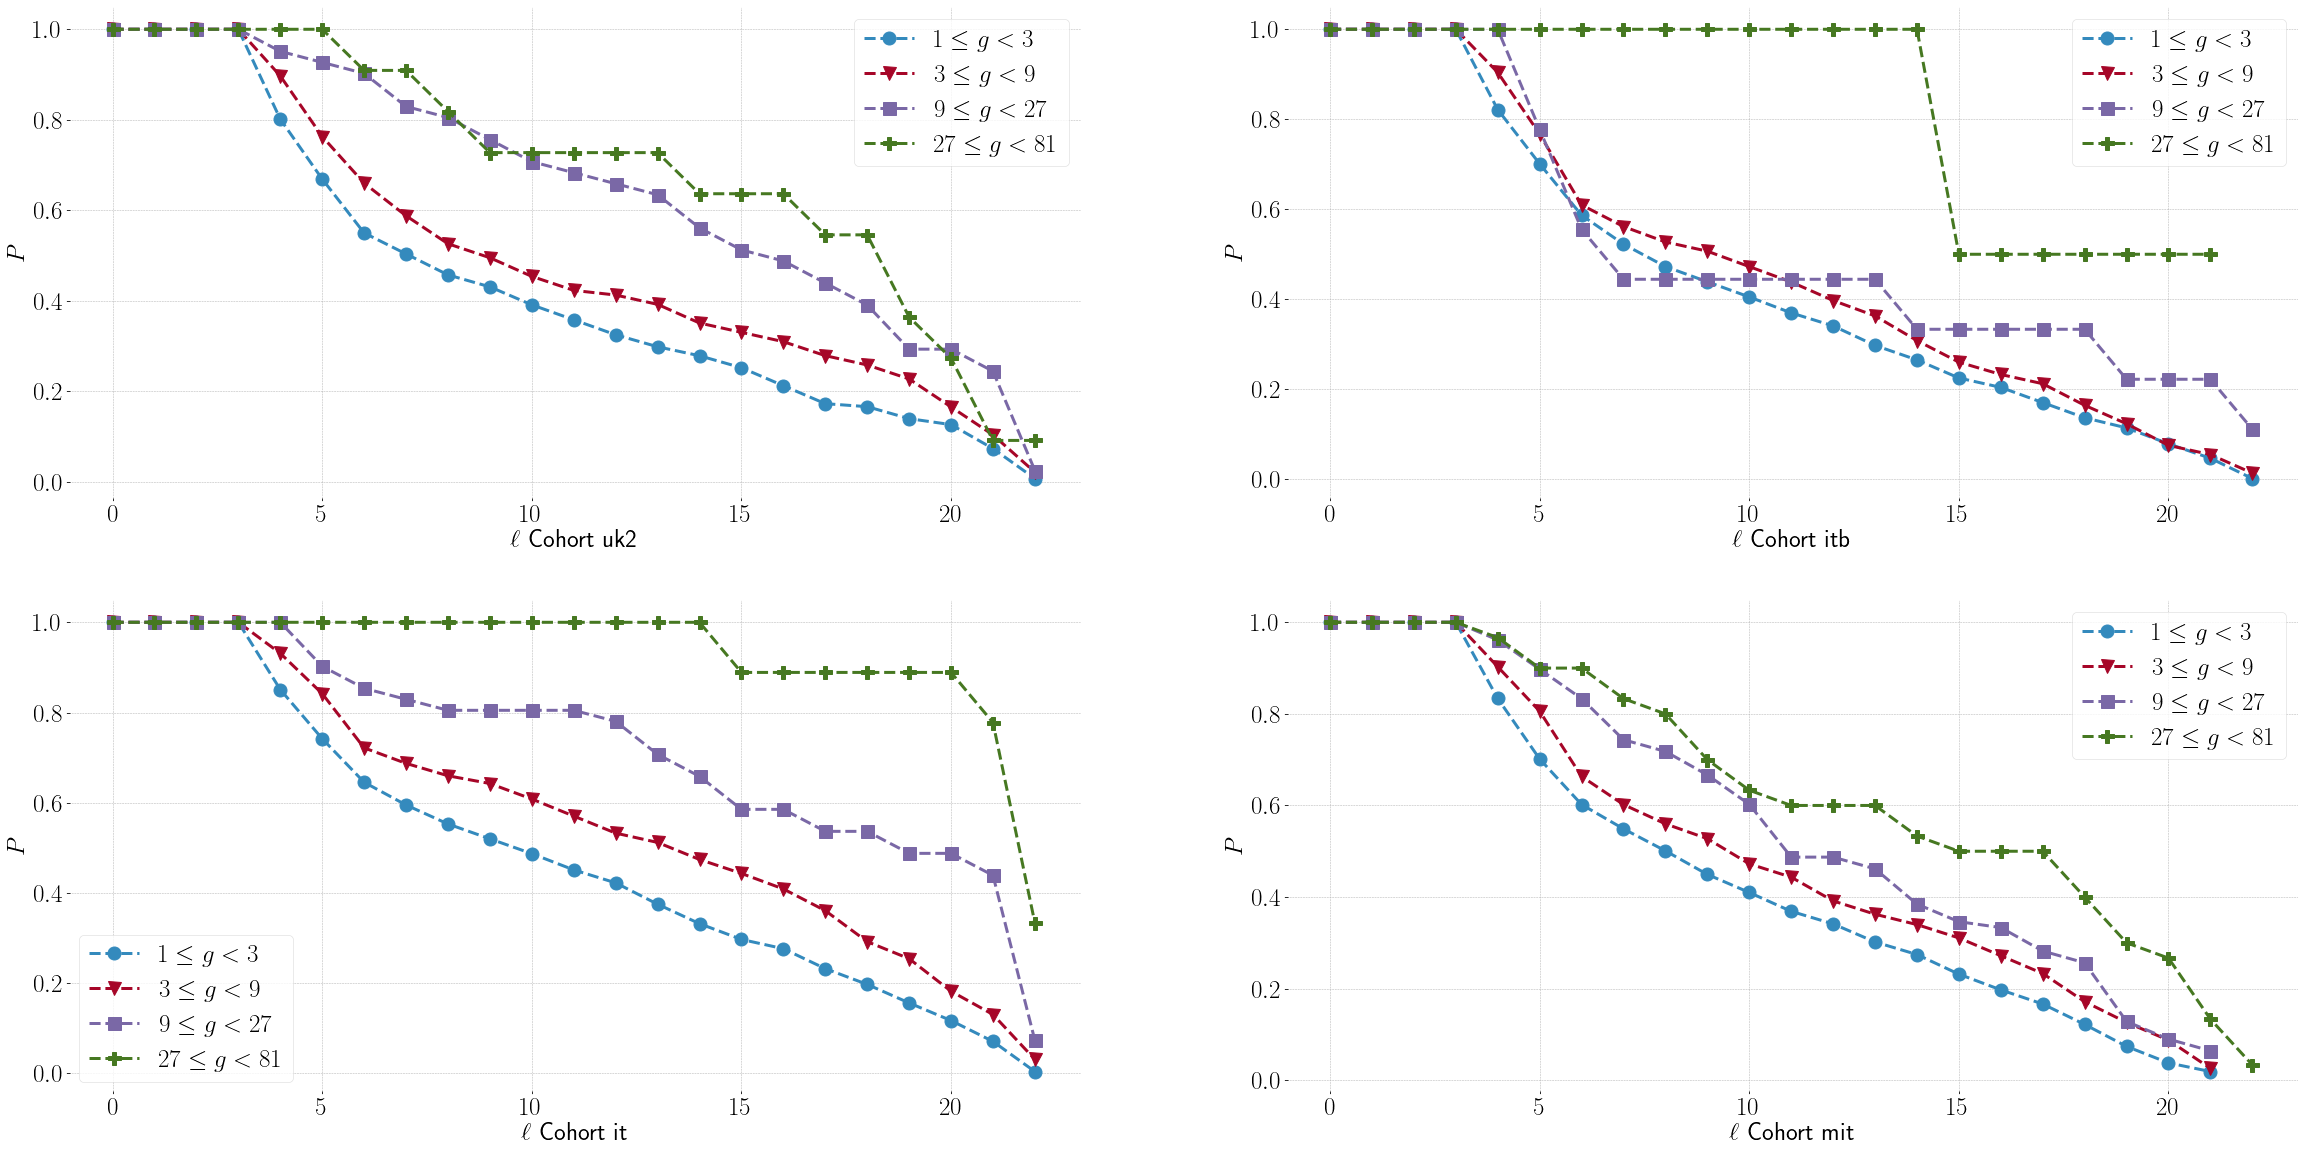

In [216]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk2', 'itb', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$\ell$ Cohort {c}")
    plt.ylabel(r"$P$")
    for i in range(4):
        plt.plot(fig3b[c][i].index, fig3b[c][i]['p'], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${3**i} \leq g < {3**(i + 1)}$')
    plt.legend()
    p += 1

In [217]:
tmp = pd.DataFrame()
for c in ['uk2', 'itb', 'it', 'mit']:
    for i in range(4):
        tmp[f'{c}{i}'] = fig3b[c][i]
        
tmp.index = tmp.index * 10
tmp.index.rename('a', inplace=True)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S7.dat", index=True, header=True, sep="\t")

In [ ]:
tmp

### Alternative function

In [ ]:
# plt.figure(figsize=(20*2, 10*2))
# p = 1
# for c in ['uk', 'uk2', 'it', 'mit']:
#     plt.subplot(2,2,p)
#     plt.xlabel(fr"$\ell$ Cohort {c}")
#     plt.ylabel(r"$P$")
#     for i in range(1,6):
#         plt.plot(fig3b[c][i].index, fig3b[c][i]['p'], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
#     plt.legend()
#     p += 1

## Change values of $a_o$ and $a_f$ for fig3

In [218]:
elements = [(0, 15), (30, 45), (60, 75), (0, 30), (30, 60), (60, 90), (0, 45), (30, 75), (60, 105), (0, 60), (30, 90), (60, 120)]

In [219]:
t0 = dt.datetime.now()
Ssva = {}
for p in range(len(elements)):
    Ssva[p + 1] = pc.get_survival2(calls['all'], elements[p][0], elements[p][1], maxell=220, base=3)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.904991


In [220]:
plt.figure(figsize=(12*3, 8*4))
for p in Ssva.keys():
    plt.subplot(4,3,p)
    plt.xlabel(fr'$a_o = {elements[p-1][0]}; \quad a_f = {elements[p-1][1]}$')
    plt.ylabel(r'P')
    for i in range(4):
        plt.plot(Ssva[p][i].index, Ssva[p][i]['p'], marker=markers[i], ls="dashed", lw=4, markersize=12, label=fr'${3**i} \leq g < {3**(i + 1)}$')
    plt.legend()

In [221]:
tmp = pd.DataFrame()
for p in Ssva.keys():
    for i in range(4):
        df = Ssva[p][i].copy(deep=True)
        df.columns=[f'p{p}s{i}']
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp.index = tmp.index * 10
tmp.index.rename('a', inplace=True)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S8.dat", index=True, header=True, sep='\t')

In [ ]:
tmp

## Distribution of $g$

In [ ]:
# dffsurv.keys()

In [222]:
gcount = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    gcount[c] = {}
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    tot = df.groupby('ea')[['time']].count().rename({'time': 'tot'}, axis='columns')
    gcount[c]['all'] = list(tot['tot'])
    df1 = df.loc[(df['aclock'] >= 30) & (df['aclock'] <= 60)]
    samp = df1.groupby('ea')[['time']].count().rename({'time': 'samp'}, axis='columns')
    gcount[c]['sample'] = list(samp['samp'])

In [223]:
gcount.keys()

dict_keys(['uk2', 'itb', 'it', 'mit'])

In [224]:
ghist = {}
for c in gcount.keys():
    ghist[c] = {}
    for s in gcount[c].keys():
        ghist[c][s] = {}
        glist = gcount[c][s]
        for n in glist:
            gamma = int(math.log(n, 3))
            ghist[c][s][gamma] = ghist[c][s].get(gamma, 0) + 1
        ghist[c][s] = pd.DataFrame.from_dict(ghist[c][s], orient='index').sort_index()
        ghist[c][s]['pmf'] = ghist[c][s][0].div(sum(ghist[c][s][0]))
        ghist[c][s]['label'] = 3**ghist[c][s].index

In [225]:
ghist['uk2']['sample']

0       pmf  label
0  151  0.500000      1
1   97  0.321192      3
2   41  0.135762      9
3   11  0.036424     27
4    2  0.006623     81

In [226]:
tmp = pd.DataFrame()
plt.figure(figsize=(20*2, 10*1))
p = 1
for s in ['all', 'sample']:
    plt.subplot(1,2,p)
    plt.xscale("log", base=2)
    plt.yscale("log")
    plt.xlabel(fr'$g$ for {s}')
    for c in ghist.keys():
        df = ghist[c][s]
        df2 = df[['pmf', 'label']]
        df2.columns = [f'p{dict({"all": "a", "sample": "s"})[s]}{c}', f'x{dict({"all": "a", "sample": "s"})[s]}{c}']
        tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
        plt.plot(df['label'], df['pmf'], label=c)
    plt.legend()
    p += 1
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S10.dat", index=False, header=True, sep="\t")

In [ ]:
for c in gcount.keys():
    print(c, max(gcount[c]['all']), max(gcount[c]['sample']))

In [ ]:
3**6

## Fig 2 using Mann Kendall Estimation

In [227]:
cols = {1: 'm', 2: 'l'}
tmp = pd.DataFrame(index=range(111))
lists = []
for c in bhist2.keys():
    for ell in [1, 2]:
        thelist = bhist2[c][ell]
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{cols[ell]}'] = thelist[i]
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2downb.dat", index=False, header=True, sep="\t")

In [228]:
cols = ['uk2m', 'itbm', 'itm', 'mitm', 'uk2l', 'itbl', 'itl', 'mitl']
pos = [0,3,6,9,1,4,7,10]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    sd = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'sd'] = sd
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 4]
b = tmp2.loc[tmp2.index >= 4]
# a.to_csv("../commpatterns/PNAS_paper/SI/figs/fig2bmdownb.dat", index=True, header=True, sep="\t")
# b.to_csv("../commpatterns/PNAS_paper/SI/figs/fig2bldownb.dat", index=True, header=True, sep="\t")

## Variations on fig4

In [230]:
callsUI = pd.DataFrame()
for c in ['uk2', 'it']:
    callsUI = callsUI.append(calls[c])
    
surv_cont = pc.get_survival2(callsUI, 30, 60, maxell=220, base=3)

In [231]:
len(callsUI) == len(calls['uk2']) + len(calls['it'])

True

In [232]:
tmp = pd.DataFrame()
for s in range(4):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 3**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/fig4ac.dat", header=False, index=False, sep="\t")

In [233]:
points_mit = pc.get_survival2(calls['mit'], 30, 60, maxell=220, binned=False)

tmp = pd.DataFrame()
for s in points_mit.keys():
    if s <= 3**4 + 1:
        df = points_mit[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
# p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/SI/fig4ap{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)


In [234]:
callsMI = pd.DataFrame()
for c in ['mit', 'it']:
    callsMI = callsMI.append(calls[c])
    
surv_cont = pc.get_survival2(callsMI, 30, 60, maxell=220, base=3)

In [235]:
tmp = pd.DataFrame()
for s in range(4):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 3**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/fig4bc.dat", header=False, index=False, sep="\t")

In [236]:
points_uk = pc.get_survival2(calls['uk'], 30, 60, maxell=220, binned=False)

tmp = pd.DataFrame()
for s in points_uk.keys():
    if s <= 3**4 + 1:
        df = points_uk[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
# p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/SI/fig4bp{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)


# Last and first days of communication for each alter

In [237]:
plt.xlabel("Days from last communication until end of data")
plt.ylabel("proportion of alters")
last = {}
last['all'] = []
first = {}
first['all'] = []
for c in ['uk2', 'itb', 'it', 'mit']:
    last[c] = []
    first[c] = []
    df = calls[c].copy(deep=True)
    if c == 'itb':
        T = max(unfiltered['it']['uclock'])
    else:
        T = max(unfiltered[c]['uclock'])
    df['ea'] = list(zip(df['ego'], df['alter']))
    l = df.groupby('ea')[['uclock']].max()
    l['days'] = l['uclock'].map(lambda i: T - 60 - i)
    if c != 'itb':
        last['all'] += list(l['days'])
    last[c] = list(l['days'])
    f = df.groupby('ea')[['uclock']].min()
    if c != 'itb':
        first['all'] += list(f['uclock'])
    first[c] = list(f['uclock'])
    H = pc.histogram(l['uclock'], 10, log=False)
    y = H['pmf'].cumsum()
    plt.plot(H['label'], y, label=c)
plt.legend()
# plt.savefig("/home/vsvh/Desktop/A.pdf", dpi=150)

In [238]:
print(f'Cohort \t Mean \t\t Median \t SD')
for c in first.keys():
    for d in [first, last]:
        print(f'{c}\t {np.mean(d[c]):.4f} \t {np.median(d[c]):.4f} \t {np.std(d[c]):.4f}')

Cohort 	 Mean 		 Median 	 SD
all	 269.4179 	 270.0000 	 138.2789
all	 155.2548 	 120.0000 	 136.8597
uk2	 119.0826 	 101.0000 	 81.6039
uk2	 110.1304 	 87.5000 	 81.9484
itb	 287.6246 	 310.0000 	 156.5321
itb	 236.6513 	 199.0000 	 147.0564
it	 292.7431 	 311.0000 	 165.3391
it	 211.4864 	 170.0000 	 160.9739
mit	 283.0358 	 274.0000 	 70.6965
mit	 97.3144 	 87.0000 	 72.0776


In [239]:
last['mit']

[21,
 106,
 78,
 164,
 119,
 4,
 54,
 57,
 103,
 163,
 182,
 119,
 149,
 0,
 214,
 106,
 251,
 233,
 76,
 120,
 26,
 100,
 23,
 167,
 54,
 90,
 107,
 69,
 75,
 76,
 65,
 55,
 187,
 75,
 113,
 79,
 206,
 172,
 22,
 161,
 15,
 90,
 124,
 252,
 8,
 134,
 11,
 72,
 120,
 0,
 127,
 105,
 9,
 64,
 0,
 4,
 184,
 103,
 82,
 250,
 127,
 119,
 103,
 114,
 120,
 226,
 127,
 152,
 19,
 207,
 13,
 159,
 113,
 26,
 17,
 238,
 105,
 43,
 4,
 30,
 20,
 102,
 196,
 49,
 182,
 29,
 162,
 67,
 152,
 210,
 35,
 21,
 14,
 184,
 177,
 95,
 206,
 191,
 152,
 47,
 76,
 44,
 172,
 210,
 210,
 152,
 229,
 48,
 30,
 20,
 209,
 69,
 97,
 168,
 20,
 152,
 217,
 189,
 130,
 196,
 3,
 5,
 232,
 108,
 3,
 144,
 68,
 50,
 251,
 99,
 251,
 67,
 45,
 45,
 203,
 6,
 196,
 222,
 141,
 251,
 75,
 128,
 129,
 62,
 5,
 160,
 21,
 198,
 35,
 152,
 16,
 226,
 48,
 218,
 133,
 159,
 43,
 40,
 208,
 177,
 148,
 230,
 131,
 33,
 64,
 244,
 33,
 54,
 195,
 161,
 132,
 223,
 2,
 46,
 133,
 24,
 46,
 181,
 134,
 81,
 5,
 2,
 114,
 2

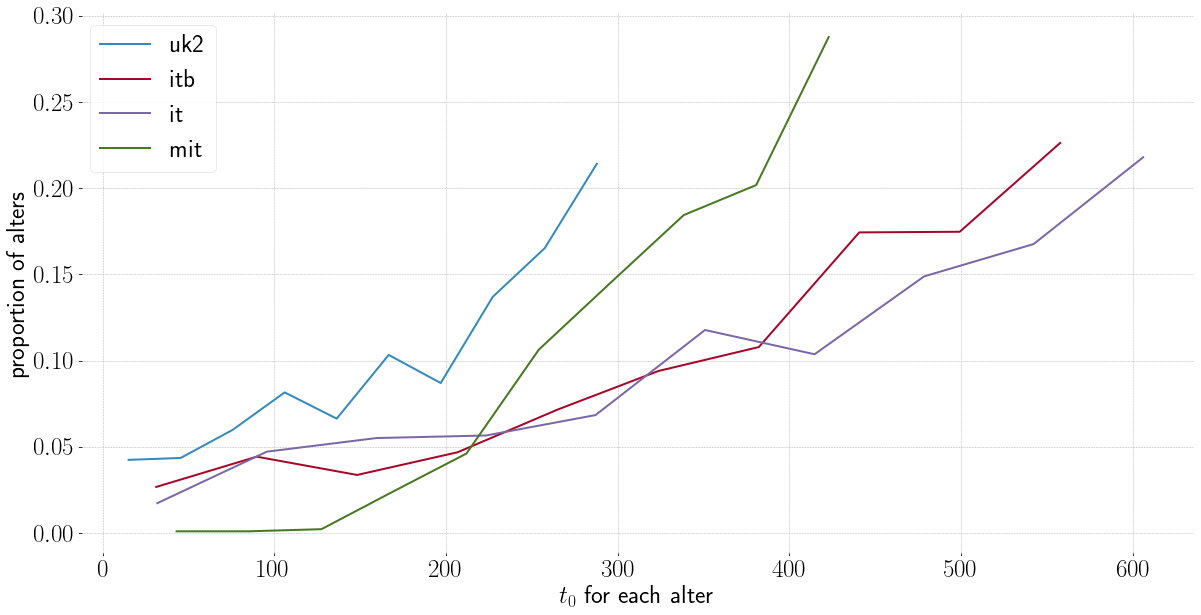

In [240]:
plt.xlabel(r"$t_0$ for each alter")
plt.ylabel("proportion of alters")
for c in ['uk2', 'itb', 'it', 'mit']:
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    last = df.groupby('ea')[['uclock']].max()
    last 
    first = df.groupby('ea')[['uclock']].min()
    H = pc.histogram(last['uclock'], 10, log=False)
    plt.plot(H['label'], H['pmf'], label=c)
plt.legend()
# plt.savefig("/home/vsvh/Desktop/B.pdf", dpi=150)

In [241]:
vis3 = {}
for c in ['uk2', 'it', 'mit']:
    vis3[c] = []
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    to = df.groupby('ea')[['uclock']].min()
    lf = df.groupby('ea')[['aclock']].max()
    df2 = to.merge(lf, left_index=True, right_index=True, how='left').rename({'uclock': 'to', 'aclock': 'lf'}, axis='columns')
    for i in df2.index:
        tup = (df2.at[i, 'lf'], df2.at[i, 'to'])
        vis3[c].append(tup)
    vis3[c].sort()

In [242]:
vis3['uk2'].index(vis3['uk2'][0])

0

In [243]:
for i in range(1, 7):
    print(i, (i - 1) % 2)

1 0
2 1
3 0
4 1
5 0
6 1


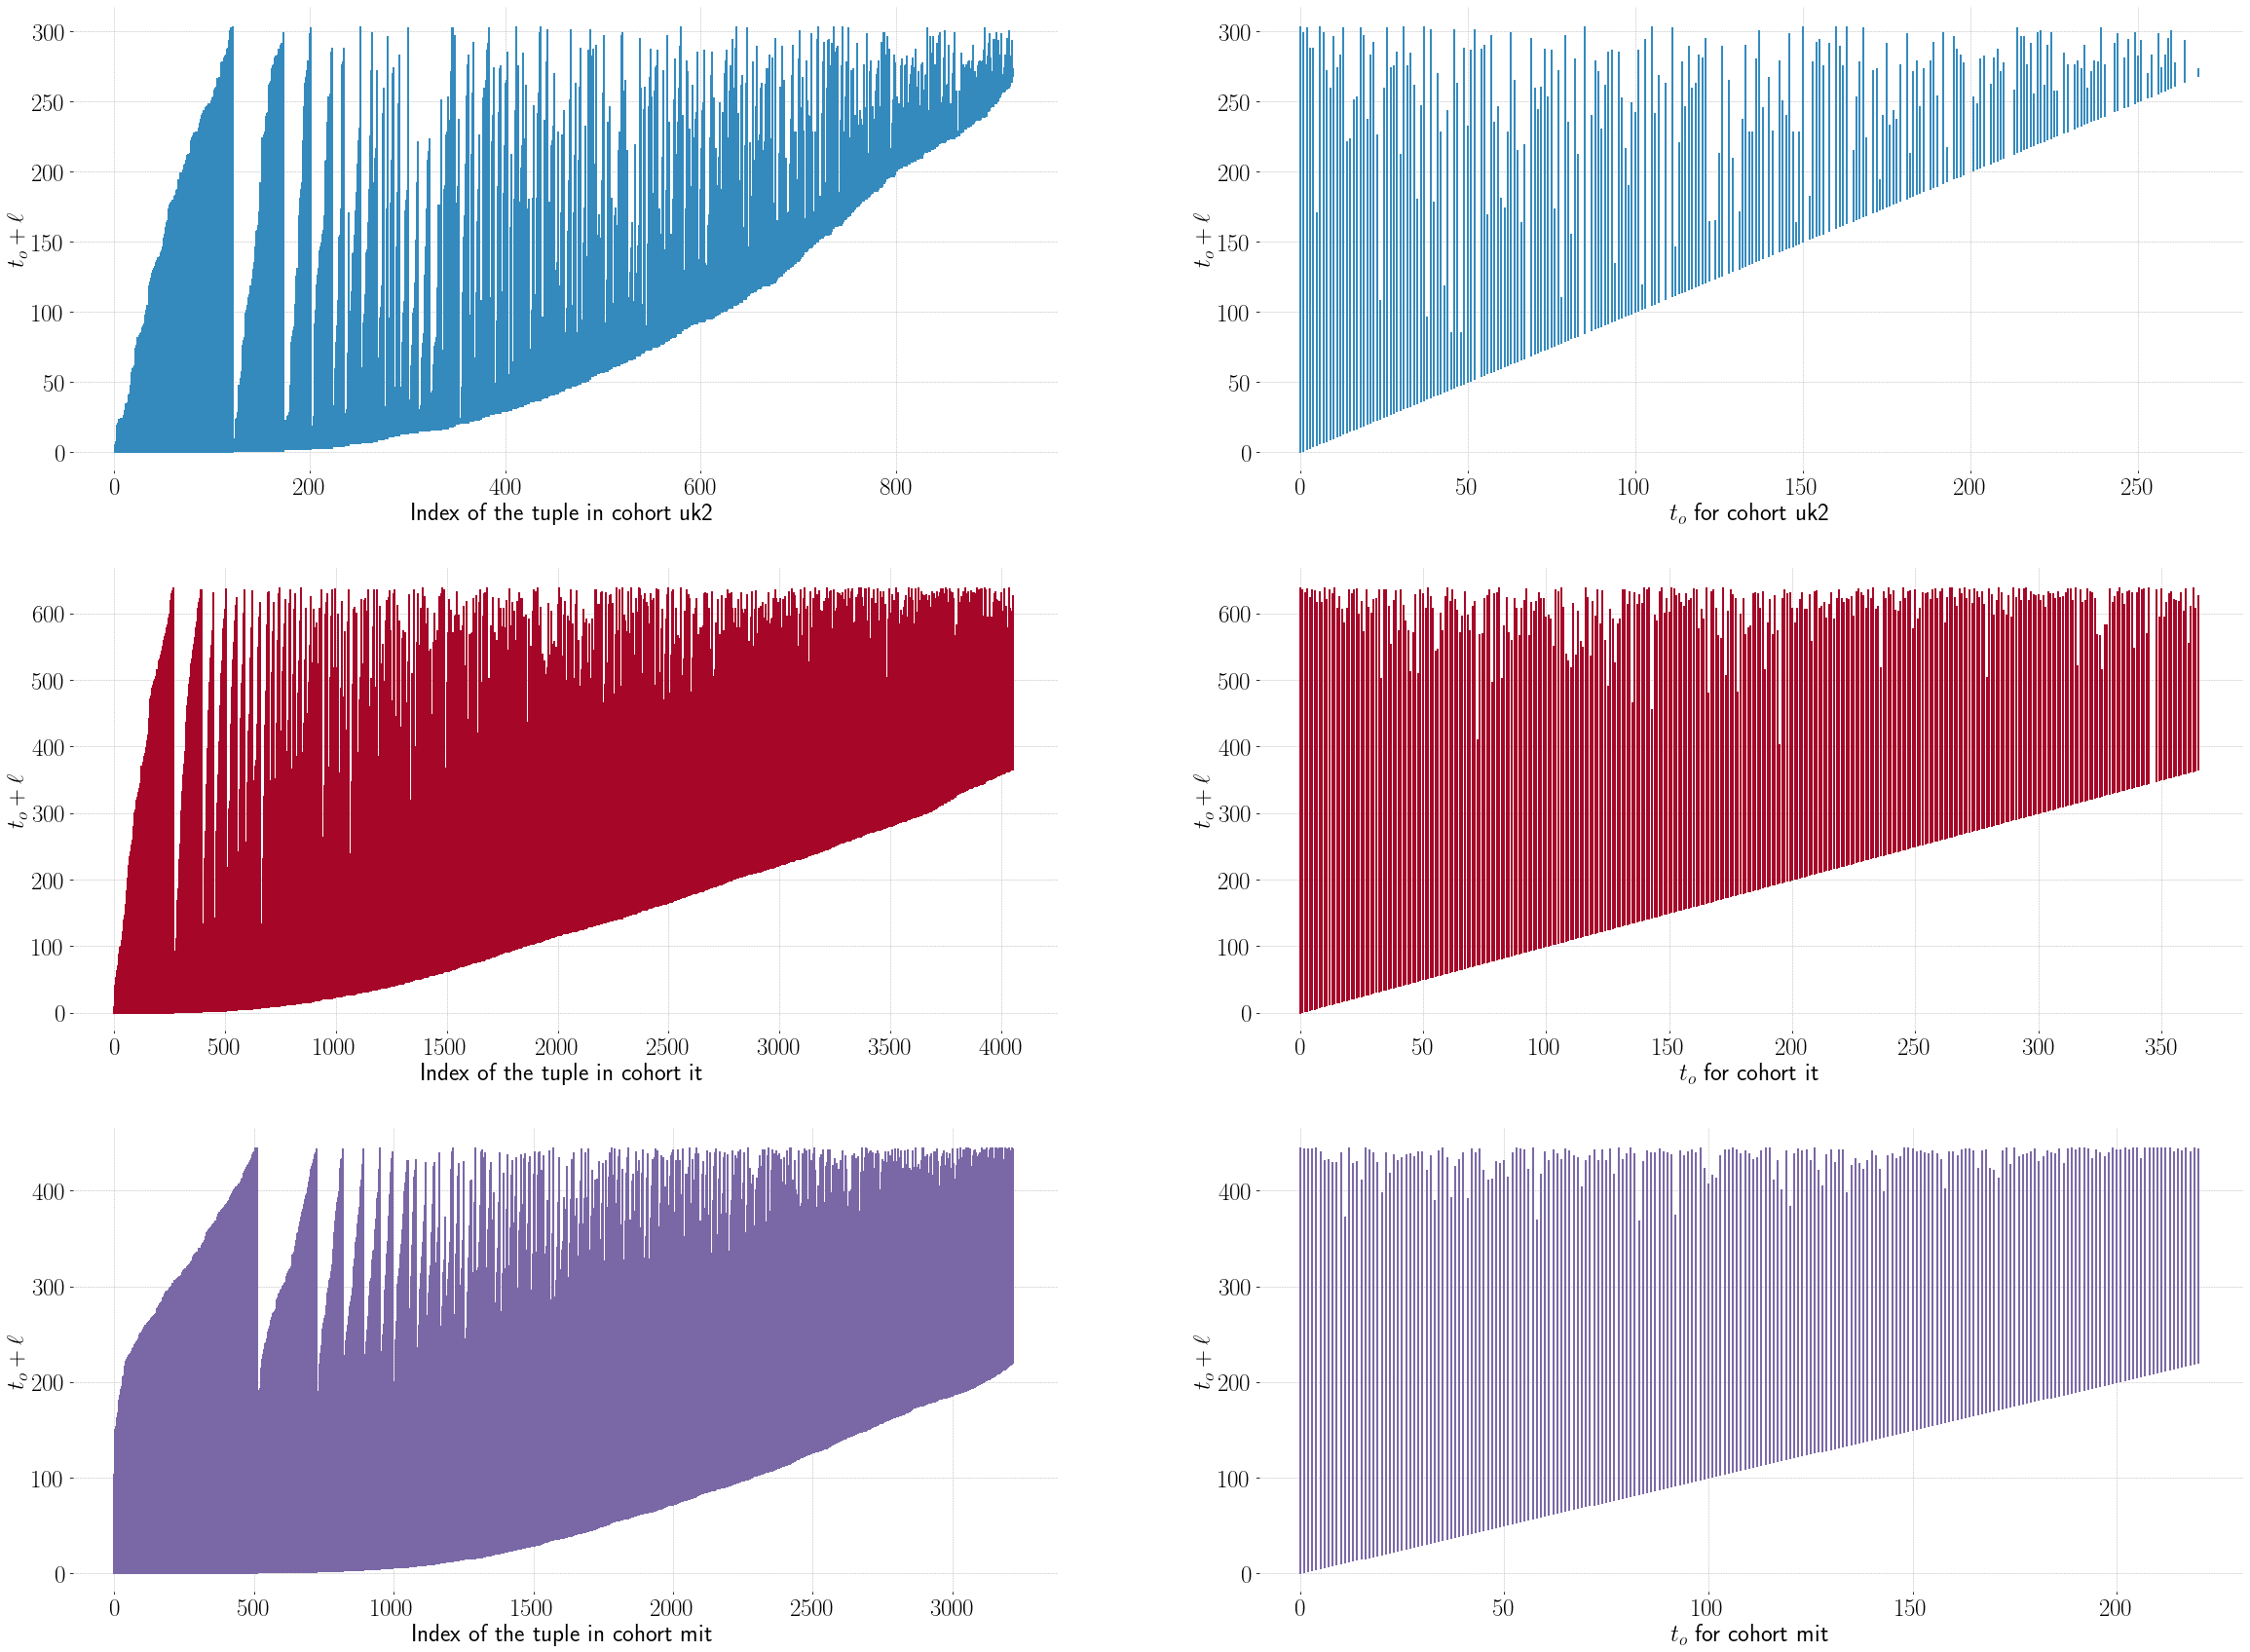

In [244]:
plt.figure(figsize=(20*2, 10*3))
p = 1
for c in ['uk2', 'uk2', 'it', 'it', 'mit', 'mit']:
    plt.subplot(3,2,p)
    if (p - 1) % 2 == 0:
        plt.xlabel(f"Index of the tuple in cohort {c}")
        plt.ylabel(r"$t_o + \ell$")
        for i in range(len(vis3[c])):
            x = [i, i]
            y = [vis3[c][i][0], vis3[c][i][0] + vis3[c][i][1]]
            if i == 0:
                plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
            else:
                plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
    else:
        plt.xlabel(fr"$t_o$ for cohort {c}")
        plt.ylabel(r"$t_o + \ell$")
        for i in range(len(vis3[c])):
            x = [vis3[c][i][0], vis3[c][i][0]]
            y = [vis3[c][i][0], vis3[c][i][0] + vis3[c][i][1]]
            if i == 0:
                plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
            else:
                plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
    p += 1
# plt.savefig("/home/vsvh/Desktop/C.pdf", dpi=300)

In [ ]:
vis4 = {}
for c in ['uk2', 'it', 'mit']:
    vis4[c] = []
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    to = df.groupby('ea')[['uclock']].min()
    lf = df.groupby('ea')[['aclock']].max()
    df2 = to.merge(lf, left_index=True, right_index=True, how='left').rename({'uclock': 'to', 'aclock': 'lf'}, axis='columns')
    for i in df2.index:
        tup = (df2.at[i, 'to'], df2.at[i, 'lf'])
        vis4[c].append(tup)
    vis4[c].sort()

In [ ]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in vis4.keys():
    plt.subplot(3,1,p)
    plt.xlabel(f"Index of the tuple in cohort {c}")
    plt.ylabel(r"$t_o + \ell$")
    plt.xlim(480, 1200)
    for i in range(len(vis4[c])):
        x = [i, i]
        y = [vis4[c][i][0], vis4[c][i][0] + vis4[c][i][1]]
        if i == 0:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
        else:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
    plt.axhline(50)
    plt.axhline(200)
    p += 1
# plt.savefig("/home/vsvh/Desktop/D.pdf", dpi=300)

In [ ]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in vis4.keys():
    plt.subplot(3,1,p)
    plt.xlabel(fr"$t_o + \text{{index within }} t_o$ in cohort {c}")
    plt.ylabel(r"$t_o + \ell$")
    allto = []
    idx = 0
    for i in range(len(vis4[c])):
        if vis4[c][i][0] not in allto:
            allto.append(vis4[c][i][0])
            idx = 0
        x = [vis4[c][i][0] + idx, vis4[c][i][0] + idx]
        y = [vis4[c][i][0], vis4[c][i][0] + vis4[c][i][1]]
        if i == 0:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
        else:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
        idx += 1
    p += 1
# plt.savefig("/home/vsvh/Desktop/E.pdf", dpi=300)

In [ ]:
def sort_check(l):
    x=l[0]
    dim=len(x)
    status=[]
    for s in range(dim):
        status.append(x[s])
    for elem in l:
        test=True
        for s in range(-1,-dim-1,-1):
            if elem[s]<status[s] and test:
                test=False
            if elem[s]>status[s] and (not test):
                test=True
        if (not test):
            print("Fail")
            return -1
        status=elem
        return 0

In [ ]:
for s in range(-1, -2-1, -1):
    print(s)

In [ ]:
for c in ['uk2', 'it', 'mit']:
    Y = [(vis4[c][i][0], vis4[c][i][0] + vis4[c][i][1]) for i in range(len(vis4[c]))]
    print(c, sort_check(Y))

In [ ]:
vis5 = {}
for c in ['uk2', 'it', 'mit']:
    # vis5[c] = []
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    to = df.groupby('ea')[['uclock']].min()
    lf = df.groupby('ea')[['aclock']].max()
    df2 = to.merge(lf, left_index=True, right_index=True, how='left').rename({'uclock': 'to', 'aclock': 'ell'}, axis='columns')
    df2 = df2.sort_values(by=['to', 'ell'])
    df3 = pd.DataFrame()
    for t0 in df2['to'].unique():
        df4 = df2.loc[df2['to'] == t0]
        df4 = df4.sort_values(by='ell')
        df4['tmp'] = 1
        df4['tmp'] = df4['tmp'].cumsum()
        df4['tmp'] -= 1
        df4['toindex'] = df4['to'] + df4['tmp']
        df4['x'] = df4['toindex'].map(lambda i: (i, i))
        df4['idx'] = df4.index
        df4['y'] = df4['idx'].map(lambda idx: (df4.at[idx, 'to'], df4.at[idx, 'to'] + df4.at[idx, 'ell']))
        df3 = df3.append(df4)
    vis5[c] = df3

In [ ]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in vis5.keys():
    plt.subplot(3,1,p)
    plt.xlabel(fr"$t_o + \text{{index within }} t_o$ in cohort {c}")
    plt.ylabel(r"$t_o + \ell$")
    for i in vis5[c].index:
        x = vis5[c].at[i, 'x']
        y = vis5[c].at[i, 'y']
        if i == list(vis5[c].index)[0]:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
        else:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
    p += 1
# plt.savefig("/home/vsvh/Desktop/E.pdf", dpi=300)

In [ ]:
vis5['it']

In [ ]:
df3 = df3.append(df4)
df3

## No filters

In [ ]:
vis6 = {}
for c in ['uk2', 'it', 'mit']:
    vis6[c] = []
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    to = df.groupby('ea')[['uclock']].min()
    lf = df.groupby('ea')[['aclock']].max()
    df2 = to.merge(lf, left_index=True, right_index=True, how='left').rename({'uclock': 'to', 'aclock': 'lf'}, axis='columns')
    for i in df2.index:
        tup = (df2.at[i, 'to'], df2.at[i, 'lf'])
        vis6[c].append(tup)
    vis6[c].sort()

In [ ]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in vis6.keys():
    plt.subplot(3,1,p)
    plt.xlabel(fr"$t_o + \text{{index within }} t_o$ in cohort {c}")
    plt.ylabel(r"$t_o + \ell$")
    allto = []
    idx = 0
    for i in range(len(vis6[c])):
        if vis6[c][i][0] not in allto:
            allto.append(vis6[c][i][0])
            idx = 0
        x = [vis6[c][i][0] + idx, vis6[c][i][0] + idx]
        y = [vis6[c][i][0], vis6[c][i][0] + vis6[c][i][1]]
        if i == 0:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
        else:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
        idx += 1
    p += 1

In [ ]:
vis7 = {}
for c in ['uk2', 'it', 'mit']:
    vis7[c] = []
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    to = df.groupby('ea')[['uclock']].min()
    lf = df.groupby('ea')[['aclock']].max()
    df2 = to.merge(lf, left_index=True, right_index=True, how='left').rename({'uclock': 'to', 'aclock': 'lf'}, axis='columns')
    for i in df2.index:
        tup = (df2.at[i, 'to'], df2.at[i, 'lf'])
        vis7[c].append(tup)
    vis7[c].sort()

In [ ]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in vis7.keys():
    plt.subplot(3,1,p)
    plt.xlabel(f"Index of the tuple in cohort {c}")
    plt.ylabel(r"$t_o + \ell$")
    for i in range(len(vis7[c])):
        x = [i, i]
        y = [vis7[c][i][0], vis7[c][i][0] + vis7[c][i][1]]
        if i == 0:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
        else:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
    p += 1
# plt.savefig("/home/vsvh/Desktop/Dnofilters.pdf", dpi=300)

### Daily stories

In [ ]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in vis7.keys():
    plt.subplot(3,1,p)
    plt.xlabel(f"Index of the tuple in cohort {c}")
    plt.ylabel(r"$t_o + \ell$")
    plt.xlim(0,1000)
    # plt.ylim(0,100)
    for i in range(len(vis7[c])):
        x = [i, i]
        y = [vis7[c][i][0], vis7[c][i][0] + vis7[c][i][1] + 1]
        if i == 0:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]], label=c)
        else:
            plt.plot(x, y, color=colors[{'uk2': 0, 'it': 1, 'mit': 2}[c]])
    p += 1

In [ ]:
vis7 = {}
for c in ['uk2', 'it', 'mit']:
    vis7[c] = []
    df = unfiltered[c].copy(deep=True)
    
    df['ea'] = list(zip(df['ego'], df['alter']))
    to = df.groupby('ea')[['uclock']].min()
    lf = df.groupby('ea')[['aclock']].max()
    df2 = to.merge(lf, left_index=True, right_index=True, how='left').rename({'uclock': 'to', 'aclock': 'lf'}, axis='columns')
    for i in df2.index:
        tup = (df2.at[i, 'to'], df2.at[i, 'lf'])
        vis7[c].append(tup)
    vis7[c].sort()

## only Italy

and $50 \leq t_o \leq 200$

In [ ]:
fwL = {}
df = calls['it'].copy(deep=True)
df['ea'] = list(zip(df['ego'], df['alter']))
to = df.groupby('ea')[['uclock']].min().rename({'uclock': 'to'}, axis='columns')
keep = to.loc[(to['to'] >= 60)]
df2 = df[df['ea'].isin(keep.index)]
for i in range(3):
    fwL[i] = pc.get_fal(df2, limits['it'][i][0], limits['it'][i][1], 15)

In [ ]:
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$')
plt.semilogy()
for i in range(3):
    plt.plot(fwL[i]['f'].index, fwL[i]['f']['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()

In [ ]:
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$')
plt.semilogy()
for i in range(3):
    plt.plot([x*15 for x in fwL[i]['f'].index], fwL[i]['f']['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()

In [ ]:
pc.get_b_slopes(fwL[1]['f'])

In [ ]:
fwL2 = {}
df = calls['it'].copy(deep=True)
df['ea'] = list(zip(df['ego'], df['alter']))
to = df.groupby('ea')[['uclock']].min().rename({'uclock': 'to'}, axis='columns')
keep = to.loc[(to['to'] >= 0) & (to['to'] <= 200)]
df2 = df[df['ea'].isin(keep.index)]
for i in range(3):
    fwL2[i] = pc.get_fal(df2, limits['it'][i][0], limits['it'][i][1], 15)

In [ ]:
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$')
plt.semilogy()
for i in range(3):
    plt.plot([x*15 for x in fwL2[i]['f'].index], fwL2[i]['f']['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()

In [ ]:
fwL3 = {}
df = calls['it'].copy(deep=True)
df['ea'] = list(zip(df['ego'], df['alter']))
to = df.groupby('ea')[['uclock']].min().rename({'uclock': 'to'}, axis='columns')
keep = to.loc[(to['to'] >= 20) & (to['to'] <= 200)]
df2 = df[df['ea'].isin(keep.index)]
for i in range(3):
    fwL3[i] = pc.get_fal(df2, limits['it'][i][0], limits['it'][i][1], 15)

In [ ]:
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$')
plt.semilogy()
for i in range(3):
    plt.plot([x*15 for x in fwL3[i]['f'].index], fwL3[i]['f']['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()

In [ ]:
fwL4 = {}
df = calls['it'].copy(deep=True)
df['ea'] = list(zip(df['ego'], df['alter']))
to = df.groupby('ea')[['uclock']].min().rename({'uclock': 'to'}, axis='columns')
keep = to.loc[(to['to'] >= 30) & (to['to'] <= 200)]
df2 = df[df['ea'].isin(keep.index)]
for i in range(3):
    fwL4[i] = pc.get_fal(df2, limits['it'][i][0], limits['it'][i][1], 15)
    
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$')
plt.semilogy()
for i in range(3):
    plt.plot([x*15 for x in fwL4[i]['f'].index], fwL4[i]['f']['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()

In [ ]:
fwL5 = {}
df = calls['it'].copy(deep=True)
df['ea'] = list(zip(df['ego'], df['alter']))
to = df.groupby('ea')[['uclock']].min().rename({'uclock': 'to'}, axis='columns')
keep = to.loc[(to['to'] >= 21) & (to['to'] <= 200)]
df2 = df[df['ea'].isin(keep.index)]
for i in range(3):
    fwL5[i] = pc.get_fal(df2, limits['it'][i][0], limits['it'][i][1], 15)
    
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$')
plt.semilogy()
for i in range(3):
    plt.plot([x*15 for x in fwL5[i]['f'].index], fwL5[i]['f']['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()

In [ ]:
min(unfiltered['it2']['time']) - min(unfiltered['it1']['time'])

In [ ]:
egos = unfiltered['it'].groupby('ego')[['uclock']].min()

In [ ]:
e1 = egos.loc[egos['uclock'] <= 50]
len(e1) / len(egos)

In [ ]:
e2 = egos.loc[(egos['uclock'] > 200) & (egos['uclock'] <= 300)]
len(e2) / len(egos)

## Italian new sample
To make sure we use the most accurate definition of $a$ and $\ell$

In [ ]:
# No Filter
df = unfiltered['it'].copy(deep=True)
df['ea'] = list(zip(df['ego'], df['alter']))
print(len(df['ea'].unique()))
# L
lf = df.groupby('ea')[['aclock']].max()
keep = lf.loc[lf['aclock'] <= 365]
df = df[df['ea'].isin(keep.index)]
print(len(df['ea'].unique()))
# Delta t to the left (by ego)
t0i = df.groupby('ego')['uclock'].min()
t0x = df.groupby('ea')[['uclock']].min()
t0x['dif'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
keep = t0x.loc[t0x['dif'] > 33]
df = df[df['ea'].isin(keep.index)]
print(len(df['ea'].unique()))
# # Delta t to the right (by ego)
# T0i = df.groupby('ego')['uclock'].max()
# T = max(df['uclock'])
# keep = []
# for ea in df['ea'].unique():
#     tmp = df.loc[df['ea'] == ea]
#     tmp = tmp.loc[tmp['uclock'] >= T0i[ea[0]] - 60]
#     if len(tmp) == 0:
#         keep.append(ea)
# df = df[df['ea'].isin(keep)]
# print(len(df['ea'].unique()))
# ncalls = df.groupby('ea')[['time']].count()
# keep = ncalls.loc[ncalls['time'] >= 3]
# df = df[df['ea'].isin(keep.index)]
# print(len(df['ea'].unique()))
# Delta t to the right
df = pc.apply_filters(df, 60)
df['ea'] = list(zip(df['ego'], df['alter']))
print(len(df['ea'].unique()))

In [ ]:
a = calls['it'].copy(deep=True)
a['ea'] = list(zip(a['ego'], a['alter']))
print(len(a['ea'].unique()))

In [ ]:
last = df.groupby('ea')[['uclock']].min()
H = pc.histogram(last['uclock'], 10, log=False)
plt.plot(H['label'], H['pmf'], label=c)

In [ ]:
max(last['uclock'])

In [ ]:
max(unfiltered['it']['uclock'])

In [ ]:
limits

In [ ]:
# limits['it'] = [(0, 50), (170, 220), (280, 330)]

In [ ]:
fig1ns = {}
for i in range(3):
    fig1ns[i] = pc.get_fal(df, limits['it'][i][0], limits['it'][i][1], 15, countalters=True)
    
plt.xlabel(r"$a$")
plt.ylabel(r"$\bar{f}(a, \ell)$")
plt.semilogy()
for i in range(3):
    plt.plot(fig1ns[i]['f'].index, fig1ns[i]['f']['f'], 
             label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]} ({fig1ns[i]["nalters"]}) [{fig1ns[i]["egocount"]}] {fig1ns[i]["nalters"] / fig1ns[i]["egocount"]:.4f}$')
plt.legend()

## Italian Loop

In [ ]:
t0 = dt.datetime.now()
itloop = {}
for i in range(3):
    itloop[i] = {}
for to in range(30, 61):
    df = unfiltered['it'].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= 365]
    df = df[df['ea'].isin(keep.index)]
    t0i = df.groupby('ego')['uclock'].min()
    t0x = df.groupby('ea')[['uclock']].min()
    t0x['dif'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
    keep = t0x.loc[t0x['dif'] > to]
    df = df[df['ea'].isin(keep.index)]
    df = pc.apply_filters(df, 60)
    df['ea'] = list(zip(df['ego'], df['alter']))
    for i in range(3):
        tmp = pc.get_fal(df, limits['it'][i][0], limits['it'][i][1], 15)
        itloop[i][to] = tmp['f']
print(f'Took {dt.datetime.now() - t0}')

In [ ]:
itavg = {}
for i in itloop.keys():
    itavg[i] = pd.DataFrame()
    for to in itloop[i].keys():
        df = itloop[i][to]
        df.columns = [f'f{to}']
        itavg[i] = itavg[i].merge(df, left_index=True, right_index=True, how='outer')
    itavg[i]['f'] = itavg[i].mean(axis=1)

In [ ]:
plt.xlabel(r'$a$')
plt.ylabel(r'$\bar{f}(a, \ell)$ per alter per ego per $t_o$')
plt.semilogy()
for i in range(3):
    plt.plot([x * 15 for x in itavg[i].index], itavg[i]['f'], label=fr'${limits["it"][i][0]} \leq \ell \leq {limits["it"][i][1]}$')
plt.legend()
# plt.savefig("/Users/vsvh/Desktop/A.pdf", dpi=150)

## Days from the beginning and end of data

In [322]:
tmp = pd.DataFrame()
plt.xlabel(r'$t_{o, ix}$')
plt.ylabel('Proportion of alters')
plt.semilogy()
m = 0
first = []
for c in ['uk2', 'itb', 'it', 'mit']:
    df  = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    if c == 'itb':
        df2 = unfiltered['it'].copy(deep=True)
        t0i = df2.groupby('ego')['uclock'].min()
    else:
        t0i = df.groupby('ego')['uclock'].min()
    t0ix = df.groupby('ea')[['uclock']].min()
    t0ix['t0'] = t0ix.index.map(lambda i: t0ix.at[i, 'uclock'] - t0i[i[0]])
    H = pc.histogram(t0ix['t0'], 20, log=False)
    H['prod'] = H['label'] * H['h']
    avg = sum(H['prod']) / sum(H['h'])
    first += list(t0ix['t0'])
    print(c, len(t0ix.loc[t0ix['t0'] < 50]), avg, np.mean(t0ix['t0']), np.median(t0ix['t0']), np.std(t0ix['t0']))
    H['y'] = H['pmf'].cumsum()
    plt.plot(H['label'], H['y'], marker=markers[m], markersize=13, ls="solid", lw=3, label=c)
    save = H[['label', 'y']]
    save.columns = [f'x{c}', f'y{c}']
    tmp = tmp.merge(save, left_index=True, right_index=True, how='outer')
    plt.legend()
    m += 1
print('all', np.mean(first), np.median(first), np.std(first))
tmp = tmp.fillna('nan')
tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S0.5a.dat", index=False, header=True, sep="\t")

uk2 291 109.90760869565217 109.29782608695652 91.0 82.70361169004924
itb 622 170.81134868421054 170.33260233918128 133.0 139.6793311312544
it 1353 151.08506910167824 149.65572556762092 100.0 145.92890561120578
mit 1271 84.62967972636815 83.60230099502488 70.0 68.96792539660296
all 131.98956426217504 94.0 126.40599487777646


In [ ]:
tmp

In [ ]:
tmp = pd.DataFrame()
plt.xlabel(r'$T_{\mathcal{E}} - t_{f, ix}$')
plt.ylabel('Proportion of alters')
# plt.semilogy()
m = 0
last = []
for c in ['uk2', 'itb', 'it', 'mit']:
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    if c == 'itb':
        T = max(unfiltered['it']['uclock'])
    else:
        T = max(unfiltered[c]['uclock'])
    tf = df.groupby('ea')[['uclock']].max()
    tf['tf'] = tf['uclock'].map(lambda i: T - i)
    last += list(tf['tf'])
    H = pc.histogram(tf['tf'], 20, log=False)
    H['prod'] = H['label'] * H['h']
    avg = sum(H['prod']) / sum(H['h'])
    print(c, avg, np.mean(tf['tf']), np.median(tf['tf']), np.std(tf['tf']))
    H['y'] = H['pmf'].cumsum()
    plt.plot(H['label'], [y for y in H['y']], marker=markers[m], markersize=13, ls="solid", lw=3, label=c)
    save = H[['label', 'y']]
    save.columns = [f'x{c}', f'y{c}']
    tmp = tmp.merge(save, left_index=True, right_index=True, how='outer')
    plt.legend()
    m += 1
print('all', np.mean(last), np.median(last), np.std(last))
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S0.5b.dat", index=False, header=True, sep="\t")

# Calls only limited by $\mathcal{L}$

In [245]:
callsb = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    callsb[c] = df

In [246]:
for c in ['uk2', 'it', 'mit']:
    T = max(callsb[c]['uclock'])
    df = callsb[c].copy(deep=True)
    T0i = df.groupby('ego')['uclock'].min()
    df['ea'] = list(zip(df['ego'], df['alter']))
    tmp = df.groupby('ea')[['uclock']].min()
    tmp['difdays'] = tmp.index.map(lambda i: tmp.at[i, 'uclock'] - T0i[i[0]])
    tmp = tmp.loc[tmp['difdays'] <= 60]
    dfl = df[df['ea'].isin(tmp.index)]
    setl = set(tmp.index)
    tmp = df.loc[df['uclock'] > T - 60]
    dfr = df[df['ea'].isin(tmp['ea'].unique())]
    setr = set(tmp['ea'].unique())
    print(c, len(setl.intersection(setr)) / (len(df['ea'].unique())))
    print(c, 'left but not right', (len(setl) - len(setl.intersection(setr))) / (len(df['ea'].unique())))
    print(c, 'right but not left', (len(setr) - len(setl.intersection(setr))) / (len(df['ea'].unique())))
    print(c, f'Left {len(dfl["ea"].unique()) / len(df["ea"].unique()):.4f}({len(dfl) / len(df):.4f})', f'Right {len(dfr["ea"].unique()) / len(df["ea"].unique()):.4f}({len(dfr) / len(df):.4f})')
    print(c, len(df['ea'].unique()))

uk2 0.0018036588508116465
uk2 left but not right 0.2285493429528472
uk2 right but not left 0.16001030662200463
uk2 Left 0.2304(0.3380) Right 0.1618(0.3684)
uk2 3881
it 0.019179642992783897
it left but not right 0.17418344094189137
it right but not left 0.14047664261298898
it Left 0.1934(0.4471) Right 0.1597(0.3102)
it 21064
mit 0.011448439620081411
mit left but not right 0.2876526458616011
mit right but not left 0.09989823609226595
mit Left 0.2991(0.5431) Right 0.1113(0.2103)
mit 11792


In [247]:
print('left', (0.17418344094189137 * 21064 + 0.3512183115924194 * 4063)/(21064 + 4063))
print('right', (0.14047664261298898 * 21064 + 0.08466650258429732 * 4063) / (21064 + 4063))

left 0.20280972658892824
right 0.1314522227086401


# $t_0$ by cohort and by $\ell$

In [248]:
Hto = {}
for c in ['uk2', 'it', 'mit']:
    Hto[c] = {}
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
    for i in range(3):
        keep = lf.loc[(lf['ell'] >= limits[c][i][0]) & (lf['ell'] <= limits[c][i][1])]
        df2 = df[df['ea'].isin(keep.index)]
        to = df2.groupby('ea')[['uclock']].min().rename({'uclock': 'to'}, axis='columns')
        Hto[c][i] = pc.histogram(to['to'], 15, log=False)

In [249]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in Hto.keys():
    plt.subplot(3,1,p)
    plt.xlabel(fr'$t_o$ in cohort {c}')
    plt.ylabel('Proportion of alters in lifetime group')
    for i in range(3):
        plt.plot(Hto[c][i]['label'], Hto[c][i]['pmf'], label=fr'${limits[c][i][0]} \leq \ell \leq {limits[c][i][1]}$')
    plt.legend()
    p += 1

In [ ]:
fwL = {}
for c in ['uk2', 'it', 'mit']:
    fwL[c] = {}
    for i in range(3):
        fwL[c][i] = pc.get_fal(callsb[c], limits[c][i][0], limits[c][i][1], 15)

In [ ]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in fwL.keys():
    plt.subplot(3,1,p)
    plt.xlabel(r"$a$")
    plt.ylabel(r"$\bar{f}(a, \ell)$")
    for i in range(3):
        plt.plot([x * 15 for x in fwL[c][i]['f'].index], fwL[c][i]['f']['f'], label=fr'${limits[c][i][0]} \leq \ell \leq {limits[c][i][1]}$')
    plt.legend()
    p += 1

# Proportion of phone calls used after filters

In [ ]:
# t0 = dt.datetime.now()
# tmp = {}
# for c in ['uk2', 'it', 'mit']:
#     tmp[c] = pc.lives_dictionary(unfiltered[c])
    
# counts = {}
# for c in ['uk2', 'it', 'mit']:
#     alters = 0
#     ncalls = 0
#     a = 0
#     cc = 0
#     counts[c] = {}
#     for i in range(0, 301, 10):
#         tmpc = pc.apply_filters(unfiltered[c], i)
#         cdf = tmpc.loc[tmpc['aclock'] <= 300]
#         tmpl = pc.lives_dictionary(cdf)
#         tmpdff = pc.get_f(cdf, 'all', 15, 10)
#         for ego in tmp[c].keys():
#             for alter in tmp[c][ego].keys():
#                 vol = tmp[c][ego][alter]['nij']
#                 alters += 1
#                 ncalls += vol
#                 if (ego in tmpl.keys()) and (alter in tmpl[ego].keys()):
#                     a += 1
#                     vol = tmpl[ego][alter]['nij']
#                     cc += vol
#             counts[c][i] = (a / alters, cc / ncalls)
#     counts[c] = pd.DataFrame({'alters': [counts[c][i][0] for i in range(10, 301, 10)], 'calls': [counts[c][i][1] for i in range(10, 301, 10)]}, index=range(10, 301, 10))
    
# print(f'This block took {dt.datetime.now() - t0}')

In [250]:
for c in ['uk2', 'it', 'mit']:
    full = unfiltered[c].copy(deep=True)
    full['ea'] = list(zip(full['ego'], full['alter']))
    ncalls = full.groupby('ea')[['time']].count()
    keep = ncalls[ncalls['time'] >= 3]
    full = full[full['ea'].isin(keep.index)]
    altf = len(full['ea'].unique())
    callsf = len(full)
    sample = calls[c].copy(deep=True)
    sample['ea'] = list(zip(sample['ego'], sample['alter']))
    alts = len(sample['ea'].unique())
    callss = len(sample)
    print(f'{c}: \t Alters: {alts/altf:.4f} \t Calls: {callss/callsf:.4f}')

uk2: 	 Alters: 0.6980 	 Calls: 0.4591
it: 	 Alters: 0.5104 	 Calls: 0.1896
mit: 	 Alters: 0.7062 	 Calls: 0.3038


## count pairs of ego alters

In [251]:
for c in ['uk2', 'itb', 'it', 'mit', 'all']:
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    print(c, len(df['ego'].unique()), len(df['ea'].unique()))

uk2 30 920
itb 142 2736
it 143 4052
mit 130 3216
all 303 8188


In [ ]:
# for c in ['uk', 'itb', 'it', 'mit']:
    # print(c, min(unfiltered[c]['time']), max(unfiltered[c]['time']), max(unfiltered[c]['time']) - min(unfiltered[c]['time']))

In [ ]:
# for c in ['uk', 'itb', 'it', 'mit']:
    # print(min(unfiltered[c]['uclock']))

In [ ]:
limits

# Mutual Information

In [252]:
miall = []
for c in ['uk2', 'itb', 'it', 'mit', 'all']:
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    ell = df.groupby('ea')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
    m2 = df.loc[(df['aclock'] >= 30) & (df['aclock'] <= 60)]
    df2 = m2.groupby('ea')[['time']].count().rename({'time': 'g'}, axis='columns')
    miall.append(df2.merge(ell, left_index=True, right_index=True, how='left'))

In [ ]:
# def get_month2(calls, lives):
#     result = pd.DataFrame()
#     idx = 0
#     for ego in dff.keys():
#         for alter in dff[ego].keys():
#             df = dff[ego][alter].loc[(dff[ego][alter]['alpha'] >= 2) & (dff[ego][alter]['alpha'] <= 3)]
#             if (len(df) > 0) and (ego in lives.keys()):
#                 result.at[idx, 'ego'] = ego
#                 result.at[idx, 'alter'] = alter
#                 result.at[idx, 'g'] = sum(df['f'])
#                 result.at[idx, 'lambda'] = lives[ego][alter]['ell']
#                 idx += 1
#     return result

In [ ]:
# miall = []
# for i in ['uk2', 'it', 'mit', 'all']:
#     miall.append(get_month2(dffsurv[i], lives['all']))

In [253]:
miall[0]['ell'].value_counts()

37     7
46     6
57     5
39     5
50     5
      ..
131    1
258    1
246    1
72     1
247    1
Name: ell, Length: 164, dtype: int64

In [254]:
import sklearn.metrics as sk
miplot = []
for i in miall:
    miplot.append(sk.mutual_info_score(i['g'], i['ell']))
for i in range(len(miplot)):
    print(['uk2', 'itb', 'it', 'mit', 'all'][i],"\t", miplot[i],"\t", miplot[i]*1.44)

uk2 	 1.8564926288266446 	 2.673349385510368
itb 	 0.633428850557719 	 0.9121375448031154
it 	 0.7067639687387579 	 1.0177401149838115
mit 	 0.946596803055993 	 1.36309939640063
all 	 0.6613343227365608 	 0.9523214247406475


In [255]:
entropies = []
for i in miall:
    X = stats.entropy([xx / sum(i["g"]) for xx in i['g']])
    Y = stats.entropy([yy / sum(i['ell']) for yy in i['ell']])
    entropies.append(np.mean([X, Y]))
    print(X, Y, np.mean([X, Y]))

4.714709903982503 5.509384660178469 5.112047282080486
6.279319494646938 6.411424199708212 6.345371847177574
6.573785551067088 6.959412522402407 6.766599036734748
6.118491948621796 6.75044640885161 6.434469178736703
7.032888149840504 7.654849731511174 7.343868940675839


In [256]:
for i in range(len(miplot)):
    print(['uk2', 'itb', 'it', 'mit', 'all'][i],"\t", miplot[i],"\t", miplot[i] / entropies[i])

uk2 	 1.8564926288266446 	 0.36316030083178236
itb 	 0.633428850557719 	 0.09982533188176648
it 	 0.7067639687387579 	 0.10444892107569151
mit 	 0.946596803055993 	 0.14711342563953986
all 	 0.6613343227365608 	 0.0900525769289804


# Finding $\mathcal{L}$

Currently, without redefining the sample, the number of ego alter pairs used is

In [ ]:
# for c in dffcomb.keys():
#     pairs = 0
#     for ego in dffcomb[c].keys():
#         for alter in dffcomb[c][ego].keys():
#             pairs += 1
#     print(c, pairs)

Now, for Italy

In [ ]:
Hfap = {}
for c in ['uk', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    fap = df.groupby('ego')[['uclock']].min()
    Hfap[c] = pc.histogram(fap['uclock'], 50, log=False)
plt.title('First appeareance of ego')    
plt.semilogy()
for c in Hfap.keys():
    plt.plot(Hfap[c]['label'], Hfap[c]['pmf'], label=c)
plt.legend()

In [ ]:
Hlf = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    Hlf[c] = pc.histogram(lf['aclock'], 50, log=False)
plt.title(r"Alter lifetime")
plt.semilogy()
# plt.xlim(-0.5, 365)
for c in Hlf.keys():
    plt.plot(Hlf[c]['label'], Hlf[c]['pmf'], label=c)
plt.axvline(225)
plt.axvline(365)
plt.legend()

In [ ]:
m = 0
tmp = pd.DataFrame()
plt.semilogy()
for c in ['uk12', 'uk', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    H = {}
    for ea in lf.index:
        ell = lf.at[ea, 'aclock'] // 10
        H[ell] = H.get(ell, 0) + 1
    H = pd.DataFrame.from_dict(H, orient='index').sort_index()
    H[f'x{c}'] = H.index.map(lambda i: (i * 10) + 5)
    H[f'y{c}'] = H[0].div(sum(H[0]))
    H = H.drop(columns=[0])
    plt.ylabel("Proportion of alters")
    plt.xlabel("Days alter was active")
    plt.plot(H[f'x{c}'], H[f'y{c}'], marker=markers[m], markersize=13, ls="dashed", lw=4, label=c)
    tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
plt.legend()
# plt.savefig("/home/vsvh/Desktop/A.pdf", dpi=200)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S0.dat", index=False, header=True, sep="\t")

In [ ]:
tmp = pd.DataFrame()
m = 0
#plt.semilogy()
for c in ['uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    df['10d'] = df['aclock'].map(lambda i: (i // 10) + 0.5)
    nego = df.groupby('10d')[['ego']].nunique()
    n = len(df['ego'].unique())
    # plt.xlim(0, 400)
    plt.ylabel("Proportion of egos")
    nego.index = nego.index * 10
    plt.xlabel("Days in each relationship")
    plt.plot(nego.index, [y / n for y in nego['ego']], marker=markers[m], markersize=13, ls="dashed", lw=4, label=c)
    nego['ego'] /= n
    nego.columns = [f'y{c}']
    tmp = tmp.merge(nego, left_index=True, right_index=True, how='outer')
    plt.axvline(270, c="black", lw=4)
    plt.axvline(365, c="black", lw=4)
plt.legend()
# plt.savefig("/home/vsvh/Desktop/B.pdf", dpi=200)
# tmp = tmp.fillna('nan')
# tmp.index.rename("a", inplace=True)
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S0.dat", index=True, header=True, sep="\t")

In [ ]:
tmp

In [ ]:
m = 0
plt.semilogy()
for c in ['uk12', 'uk', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    df['10d'] = df['aclock'].map(lambda i: (i // 10) + 0.5)
    nalt = df.groupby('10d')[['ea']].nunique()
    nego = df.groupby('10d')[['ego']].nunique()
    prop = nego.merge(nalt, left_index = True, right_index = True, how='outer')
    prop['prop'] = prop['ea'] / prop['ego']
    plt.ylabel("Number of alters per ego")
    plt.xlabel("Days in each relationship")
    plt.plot([10 * x for x in prop.index], prop['prop'], marker=markers[m], markersize=13, ls="dashed", lw=4, label=c)
    plt.axvline(365, color='black', lw=3)
    plt.axvline(300, color='black', lw=3)
    plt.axvline(250, color='black', lw=3)
plt.legend()
plt.savefig("/home/vsvh/Desktop/C.pdf", dpi=200)

In [ ]:
it = unfiltered['it'].copy(deep=True)
it['ea'] = list(zip(it['ego'], it['alter']))
itlf = it.groupby('ea')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
keep = itlf.loc[itlf['ell'] <= 365]
it = it[it['ea'].isin(keep.index)]
it = pc.apply_filters(it, 60)

In [ ]:
it['ea'] = list(zip(it['ego'], it['alter']))
print(len(it['ea'].unique()))
lf = it.groupby('ea')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
H = pc.histogram(lf['ell'], 50, log=False)
plt.semilogy()
plt.plot(H['label'], H['pmf'])

In [ ]:
newlim = [(0, 50), (100, 150), (250, 300)]

In [ ]:
new1 = {}
for i in range(3):
    new1[i] = pc.get_fal(it, newlim[i][0], newlim[i][1], 15, countalters=True)

In [ ]:
# plt.figure(figsize=(20*2, 10*1))
# plt.subplot(121)
# plt.title("New sampling")
# plt.semilogy()
# for i in range(3):
#     plt.plot(new1[i]['f'].index, new1[i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${newlim[i][0]}\leq \ell \leq {limits[i][1]}$')
# plt.legend()
# plt.subplot(122)
# plt.title("Sampling from the paper")
# plt.semilogy()
# for i in range(3):
#     plt.plot(fig1['it'][i]['f'].index, fig1['it'][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
# plt.legend()

In [ ]:
# new2 = {}
# for i in range(3):
#     new2[i] = pc.get_avgfa(dffcomb['uk'], lives['uk'], newlim[i][0], newlim[i][1])

In [ ]:
# plt.figure(figsize=(20*2, 10*1))
# plt.subplot(121)
# plt.title("New sampling")
# plt.semilogy()
# for i in range(3):
#     plt.plot(new2[i].index, new2[i]['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${newlim[i][0]}\leq \ell \leq {newlim[i][1]}$')
# plt.legend()
# plt.subplot(122)
# plt.title("Sampling from the paper")
# plt.semilogy()
# for i in range(3):
#     plt.plot(fig1['uk'][i]['f'].index, fig1['uk'][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
# plt.legend()

In [ ]:
# new3 = {}
# for i in range(3):
#     new3[i] = pc.get_avgfa(dffcomb['mit'], lives['mit'], newlim[i][0], newlim[i][1])

In [ ]:
# plt.figure(figsize=(20*2, 10*1))
# plt.subplot(121)
# plt.title("New sampling")
# plt.semilogy()
# for i in range(3):
#     plt.plot(new3[i].index, new3[i]['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${newlim[i][0]}\leq \ell \leq {newlim[i][1]}$')
# plt.legend()
# plt.subplot(122)
# plt.title("Sampling from the paper")
# plt.semilogy()
# for i in range(3):
#     plt.plot(fig1['mit'][i]['f'].index, fig1['mit'][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
# plt.legend()

In [ ]:
# egolist = {}
# for c in ['it1', 'it2']:
#     egolist[c] = [ego[1:] for ego in dffcomb[c].keys()]

# intersections = {}
# for ego in egolist['it1']:
#     if ego in egolist['it2']:
#         set1 = {alter for alter in dffcomb['it1'][f'a{ego}'].keys()}
#         set2 = {alter for alter in dffcomb['it2'][f'b{ego}'].keys()}
#         intersections[ego] = set1.intersection(set2)

In [ ]:
# tot = 0
# rep = 0
# for ego in intersections.keys():
#     tot += 1
#     if len(intersections[ego]) > 0:
#         rep += 1
# print(f'Total egos: \t{tot}')
# print(f'Egos with repetition: \t{rep} ({(rep/tot) * 100:.2f}%)')

In [ ]:
# intersections

In [ ]:
# a = unfiltered['it'].loc[(unfiltered['it']['ego'] == 28) & (unfiltered['it']['alter'] == '176577f07de42298c204581415ca579e')]
# a

In [ ]:
# max(a['uclock']) - min(a['uclock'])

In [ ]:
# it.loc[(it['ego'] == 28) & (it['alter'] == '176577f07de42298c204581415ca579e')]

# Testing area

In [ ]:
# general_count = 0
# uk1_count = 0
# for ego in dffcomb['uk'].keys():
#     for alter in dffcomb['uk'][ego].keys():
#         general_count += 1
#         if ego[0] == 'a':
#             uk1_count += 1
# uk1_count / general_count

In [ ]:
# min(unfiltered['it']['time'])

# Correlation between number of calls and call duration

In [305]:
datadur = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    datadur[c] = None

In [306]:
datadur['mit'] = pc.allcalls('../usadata/CallLog.csv', ('type', 'outgoing', 'outgoing+', 'missed'), 'participantID.A', 'number.hash', 
                                ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=3, duration='duration')

In [307]:
raichu = pc.allcalls("../ukdata/collected_dunbar_calls_v3_e26OK_sorted.csv", (3, 'call'), 1, 2, [6,7], '%d/%m/%y %H:%M', header=False, min_activity=3, duration=4)
# datadur['uk'] = raichu

In [308]:
print(len(raichu['pair'].unique()))
t0ix = raichu.groupby('pair')[['t']].min()
keep = t0ix.loc[t0ix['t'] >= 180]
pikachu = raichu[raichu['pair'].isin(keep.index)]
len(pikachu['pair'].unique())
pikachu['t'] -= 180

2736


/tmp/ipykernel_2325/2289999485.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pikachu['t'] -= 180


In [309]:
print([min(pikachu['a']), max(pikachu['a'])])
print([min(pikachu['t']), max(pikachu['t'])])

[0, 348]
[0, 365]


In [310]:
datadur['uk2'] = pikachu

In [311]:
with open("../itdata/MTLwDuration.pkl", 'rb') as data:
    tmp = pickle.load(data)
    tmp = tmp['it']
    datadur['it'] = tmp
    data.close()

In [312]:
df = datadur['it'].copy(deep=True)
print(len(df['pair'].unique()))
t0i = df.groupby('ego')['t'].min()
t0x = df.groupby('pair')[['t', 'ego']].min()
t0x['dif'] = t0x.index.map(lambda i: t0x.at[i, 't'] - t0i[t0x.at[i, 'ego']])
keep = t0x.loc[t0x['dif'] > 50]
datadur['itb'] = df[df['pair'].isin(keep.index)]
print(len(datadur['itb']['pair'].unique()))

23674
18751


In [313]:
for c in datadur.keys():
    df = datadur[c].copy(deep=True)
    # L
    lf = df.groupby('pair')[['a']].max()
    keep = lf.loc[lf['a'] <= L[c]]
    df = df[df['pair'].isin(keep.index)]
    # Delta t to the right
    datadur[c] = pc.apply_filters2(df, 60)

In [314]:
datadur['all'] = pd.DataFrame()
for c in ['uk2', 'itb', 'it', 'mit']:
    if c != 'itb':
        datadur['all'] = datadur['all'].append(datadur[c])

In [315]:
len(datadur['all']) == len(datadur['uk2']) + len(datadur['it']) + len(datadur['mit']) 

True

In [316]:
for c in datadur.keys():
    print(c, [min(datadur[c]['a']), max(datadur[c]['a'])], [min(datadur[c]['t']), max(datadur[c]['t'])], len(datadur[c]['pair'].unique()))

uk2 [0, 268] [0, 304] 926
itb [0, 365] [51, 638] 2825
it [0, 365] [0, 638] 4052
mit [0, 220] [2, 444] 3194
all [0, 365] [0, 638] 8172


In [317]:
corrs = {}
for c in datadur.keys():
    df = datadur[c].copy()
    n = df.groupby('pair')[['time']].count().rename({'time': 'n'}, axis='columns')
    dur = df.groupby('pair')[['duration']].sum()
    corrs[c] = n.merge(dur, left_index=True, right_index=True, how='outer')

In [318]:
nr = 3
nc = 2
plt.figure(figsize=(16*nc, 8*nr))
p = 1
for c in corrs.keys():
    plt.subplot(nr,nc,p)
    plt.loglog()
    plt.ylabel(fr"Number of calls. Cohort {c}")
    plt.xlabel("Duration of calls")
    plt.scatter(corrs[c]['duration'], corrs[c]['n'])
    plt.annotate(fr'$r = {np.corrcoef(corrs[c]["n"], corrs[c]["duration"])[0,1]:.4f}$', (7, 100), fontsize=25)
    p += 1

In [304]:
# for c in corrs.keys():
#     df = pd.DataFrame({f'x{c}': corrs[c]['duration'], f'y{c}': corrs[c]['n']}).reset_index(drop=True)
#     df.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S2.7{c}.dat", index=False, header=True, sep="\t")

In [321]:
for c in corrs.keys():
    print(c, corrs[c]['duration'].corr(corrs[c]['n'], method='spearman'))

uk2 0.5485840118321847
itb 0.4971339521318879
it 0.5853382024006892
mit 0.22607710365026573
all 0.2687136987035369


# Global Time

In [ ]:
globaltf = dt.datetime.now() - globalt0
print(f'This notebook took {globaltf}')
os.system(f"notify-send 'Notebook done' 'it took {globaltf}'")